## Get the cross corr between pairs of cells on each shank in RF 

1. So based on the jupyter below we find out that FS has expected value before the gc. 
2. Then I wanted to chec whether this also hold true for Pairs of GS and fs 
3. while I was checking for the cells in one session I found that some FS change their firing activity based on light and dark condition 
4. Then we were wondering if we get pairs of FS and gc do I see the same
5. at the end when I was checking the pairs of FS and GC that are in the same shank I did found that in light all the FS fire before the GC but not in dark
6. Then we were wondering if all the cells on the same shank are connected or not 
7. Then I need to calculate the cross correlation between each pair that are on the same shank and calculate the corr of their stacked_if at the lever and check if this value is more than the shuffled vale (if I shuffle the firing time on each trial randomly and then get the corr.)
8. Then if I calculate that for one session 

1. /autopi_inter/lever_press/TrialMatrix_leverPress_Pascal_8.ipynb


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../neuronAutopi.py

%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os
from itertools import product
from scipy.stats import pearsonr
from scipy import signal
from scipy.signal import find_peaks
import itertools


projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [32]:
#prepareSessionsForSpatialAnalysisProject(sSessions[152:156],myProject.sessionList[152:156]) ### sSeslist >>>> sSessions
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [05:52<00:00,  1.96s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [33]:
#for ses, sSes in tqdm(zip(myProject.sessionList[152:156],sSessions[152:156])):
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
    getSearchHomingIntervals(ses,sSes)

180it [00:05, 31.35it/s]


In [4]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 149 ms, sys: 7.5 ms, total: 157 ms
Wall time: 188 ms


In [5]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 


In [6]:
def samples2time(l):
    return bin_size_sec*(np.arange(l)-l/2+.5)

def pcorr(a,b):
    r,p=pearsonr(a.flatten(),b.flatten())
    return r

def normalize_zscore(x):
    return (x-np.mean(x))/np.std(x)

def corr_norm(x,y,mode="full"):
    x_=normalize_zscore(x)
    y_=normalize_zscore(y)
    return np.correlate(x_,y_,mode=mode)/len(x)
    
def corr_norm_2d(A,B):
    C = np.nanmean([corr_norm(a,b) for a,b in zip(A,B)], axis=0)
    shifts = np.arange(len(C))-len(C)//2
    return C, shifts
    

In [7]:
def get_stacked_ifr_all_cropped(sSes,ses):
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values
    
    atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    
    
    
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})
            
            
            
    atLeverIFR_trials = [] # number of trials * number of cells * time

    for t in trial_lever_times:
        start,end = t['start'],t['end']

        # IFR around lever for each trial
        atLeverifr = [] # number of cells * time

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(np.array([start,end]))
            n.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma, time_start=start, time_end=end, outside_interval_solution="remove")
            n.spike_train.ifr[0][n.spike_train.ifr[0] > 80] = 0
            atLeverifr.append(n.spike_train.ifr[0])
        atLeverifr = np.array(atLeverifr) # number of cells * trial duration
        atLeverIFR_trials.append(atLeverifr)
        
        
    # get time before and after leverpress for aligned stack
    dt=[]
    for t in trial_lever_times:
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        dt.append(max(leverpress-start, end-leverpress))
    maxtime = np.max(dt)
    
    time_samples = int(np.ceil(maxtime/bin_size_sec)) # before and after lever press


    # stack : trials * time * cells
    # time aligning is by trial

    ncells = len(sSes.cg.neuron_list)
    ntrials = len(trial_lever_times)
    stackedifr_cells = np.zeros((ntrials, ncells, time_samples*2))
    stackedifr_cells[:] = np.nan # pad empty space with nan

    for i, (atLeverifr, t) in enumerate(zip(atLeverIFR_trials, trial_lever_times)):
        # print('trial',i,t,'/',"IFR shape:",atLeverifr.shape)
        # align trials
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        left_pad_samples = time_samples - int(np.ceil((leverpress-start)/bin_size_sec)) # how many nans to add before start (for this trial, all cells), so that lever press is centered
        stackedifr_cells[i,:,left_pad_samples:left_pad_samples+atLeverifr.shape[1]] = atLeverifr

    trial_ids = np.array([t['trial_id'] for t in trial_lever_times])
    # mask for light or dark
    trial_light = (session_trials.light == 'light').values
    trial_light_onids = trial_light[trial_ids]

    trials_light_ids = np.where(trial_light_onids)[0]
    trials_dark_ids = np.where(~trial_light_onids)[0]
    
    ###############
    #### Crop the stack 0.5 second before and after the leverPress to remove Nans 
    ##############
    time = samples2time(time_samples*2)

    # crop
    samples_to_keep = 50 #100
    indx0,indx1 = len(time)//2-samples_to_keep//2, len(time)//2+samples_to_keep//2
    time_scaled = time[indx0:indx1]
    stackedifr_cells = stackedifr_cells[:,:,indx0:indx1]
    #time, stackedifr_cells.shape

    #return stackedifr_cells, trials_light_ids, trials_dark_ids, time, time_scaled 
    return stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled 

## Get the spike time cross correlation

In [8]:
def get_crossCorrPairs_interval(sSes, pair, interName= 'circ80_1', bin_size_sec= 0.0005, cc_cell_order= 'fs_gc'):
    
    """
    Computes the spike time cross-correlation between the spike trains of two neurons over a specified time interval, 
    and returns the time-stamped histogram of spike counts.

    Parameters:
    ----------
    sSes : object
        The session object containing the neuron data and spike train information. 
        It should have attributes like `cg.neuron_list` and `intervalDict`.

    pair : tuple of str, pair= (fsId,gcId) that has the cluid of the fs and then the gc 
        

    interName : str, optional, default='circ80_1'
        The name of the time interval to use for the cross-correlation, which should be a key in 
        `sSes.intervalDict`. This defines the window over which the spike trains are analyzed.

    bin_size_sec : float, optional, default=0.02
        The size of the bins in seconds for the histogram. This defines the resolution of the 
        cross-correlation output.

    Returns:
    -------
    timestamp : array-like
        A 1D array of midpoints of the bins, representing the time at which each bin in the histogram occurs.
    
    hist : array-like
        A 1D array representing the spike count histogram for the cross-correlation between the two neurons' 
        spike trains. Each value corresponds to the spike counts within a specific time bin.
    """
    fsId= pair[0]
    gcId= pair[1]
    sSes,ses,gcn, gcnid = get_sSesId_nId(gcId)
    sSes,ses,fsn, fsnid = get_sSesId_nId(fsId)
    
    gcn.spike_train.unset_intervals()
    fsn.spike_train.unset_intervals()
    
    gcn.spike_train.set_intervals(ses.intervalDict[interName])
    fsn.spike_train.set_intervals(ses.intervalDict[interName])
    
    if cc_cell_order== 'fs_gc':

        hist,edges= fsn.spike_train.spike_time_crosscorrelation(st1=fsn.spike_train.st, st2=gcn.spike_train.st,  bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
        timestamp = fsn.spike_train.mid_point_from_edges(edges)
    elif cc_cell_order== 'gc_fs':
        hist,edges= fsn.spike_train.spike_time_crosscorrelation(st1=gcn.spike_train.st, st2=fsn.spike_train.st, bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
        timestamp = fsn.spike_train.mid_point_from_edges(edges)
        
    return timestamp, hist


In [116]:
def get_p1_FromCrossCorrPairs(hist, timestamp):
    
    """
    Identifies the first peak in a given histogram of spike times, calculates its corresponding 
    timestamp and spike count, and determines the time difference of the peak from zero.

    Parameters:
    ----------
    hist : array-like
        A 1D array representing the spike count histogram, typically from a cross-correlation 
        between two spike trains.

    Returns:
    -------
    p1_time : float
        The timestamp corresponding to the first peak in the histogram. If no peak is found, 
        this returns NaN.
    
    p1_height : float
        The spike count at the first peak in the histogram. If no peak is found, this returns NaN.
    
    p1diff : float
        The time difference between the first peak and 0. If no peak is found, this returns NaN.
    """
    # Check if all values in hist are zero
    if np.all(hist == 0):
        p1_time = np.nan
        p1_height = np.nan
        p1_height_zscore = np.nan
        
    else:
        # Use np.nanmax to get the maximum peak height
        p1_height = np.nanmax(hist)

        # Find the index of the peak corresponding to the max value
        #highest_peak_idx = np.where(hist == p1_height)[0][0]
        highest_peak_idx = np.argmax(hist) ## argmax
        
        p1_height_zscore = (p1_height-np.mean(hist))/np.std(hist) # p1_height = p1_height_zscore*np.std(hist) + np.mean(hist)

        # Get the timestamp corresponding to the highest peak
        p1_time = timestamp[highest_peak_idx]
        #p1diff = p1_time - 0

    return p1_time, p1_height_zscore
    #return p1_time, p1_height, p1_height_zscore
    
def get_pair_st(pair, sSes, interName= 'circ80_1'):
    '''
    pair is the pair= (fsId,gcId) 
    '''
    sSes,ses,gcn, gcnid = get_sSesId_nId(pair[0])
    sSes,ses,fsn, fsnid = get_sSesId_nId(pair[1])

    gcn.spike_train.set_intervals(ses.intervalDict[interName])
    fsn.spike_train.set_intervals(ses.intervalDict[interName])

    fsn_st= fsn.spike_train.st
    gcn_st= gcn.spike_train.st
    
    return fsn_st, gcn_st

In [46]:
sSes= sSessions[152]
ses= myProject.sessionList[152]
interName= 'circ80_1'
gcId= cells[(cells.session== sSes.name) & (cells.gridCell_FIRST)].cluId.iloc[2]
fsId= cells[(cells.interneuron) & (cells.session== sSes.name) & (cells.mrate_RF1> 10)].cluId.iloc[0]
sSes,ses,gcn, gcnid = get_sSesId_nId(gcId)
sSes,ses,fsn, fsnid = get_sSesId_nId(fsId)

pair= (fsId,gcId)

(-0.5, 42.5, 42.5, -0.5)

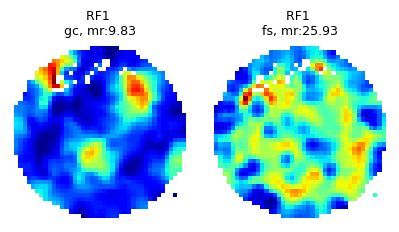

In [47]:
col, row = 2, 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)

ax= fig.add_subplot(gs[0,0])
gcn.set_spatial_properties(gcn.ap)
gcn.ap.set_intervals(ses.intervalDict[interName])
gcn.spike_train.set_intervals(ses.intervalDict[interName])
gcn.spatial_properties.firing_rate_map_2d()
ax.imshow(gcn.spatial_properties.firing_rate_map, cmap='jet',interpolation=None)
ax.set_title('RF1 \ngc, mr:{:.2f}'.format(cells[(cells.cluId== gcId)].mrate_RF1.iloc[0]), fontsize= 9)

ax.axis('Off')

fsn.set_spatial_properties(gcn.ap)
fsn.ap.set_intervals(ses.intervalDict[interName])
fsn.spike_train.set_intervals(ses.intervalDict[interName])
fsn.spatial_properties.firing_rate_map_2d()
ax= fig.add_subplot(gs[0,1])
ax.imshow(fsn.spatial_properties.firing_rate_map, cmap='jet',interpolation=None)
ax.set_title('RF1 \nfs, mr:{:.2f}'.format(cells[(cells.cluId== fsId)].mrate_RF1.iloc[0]), fontsize= 9)
ax.axis('Off')


## Get the heigest peak 

## define the threshold 6std of the baseline and the time of the peak which is less than 4 ms 

In [93]:
def find_peaks_higher_than_threshold(hist, timestamp, timestd=6):
    if np.all(hist == 0):
        peaks_heights_above_thr = np.nan
        thr = np.nan
        peak_times = np.nan
    else: 
        mean = hist.mean()
        std = hist.std()
        thr = mean + timestd * std

        # Find all peaks
        peaks, properties = find_peaks(hist)
        peak_heights = hist[peaks]

        # Filter peaks that are higher than the threshold
        peaks_heights_above_thr = peak_heights[peak_heights >= thr]

        # Check if there are peaks higher than the threshold
        if len(peaks_heights_above_thr) != 0:
            # Get the indices of the peaks that exceed the threshold
            peaks_idx = peaks[peak_heights >= thr]
            peak_times = timestamp[peaks_idx]
        else: 
            peaks_heights_above_thr = np.nan  # Set this to np.nan if no peaks above threshold
            peak_times = np.nan

    return thr, peaks_heights_above_thr, peak_times

def find_highest_peak_above_threshold(hist, timestamp, timestd=6):
    if np.all(hist == 0):
        # If hist is all zeros, return NaN values
        thr = np.nan
        highest_peak_above_thr = np.nan
        peak_time = np.nan
    else:
        # Calculate threshold
        mean = hist.mean()
        std = hist.std()
        thr = mean + timestd * std

        # Find all peaks
        peaks, properties = find_peaks(hist)
        peak_heights = hist[peaks]

        # Filter peaks that are higher than the threshold
        peaks_above_thr = peaks[peak_heights >= thr]
        peaks_heights_above_thr = peak_heights[peak_heights >= thr]

        # Check if there are peaks above the threshold
        if len(peaks_heights_above_thr) > 0:
            # Get the highest peak above threshold
            max_index = np.argmax(peaks_heights_above_thr)
            highest_peak_above_thr = peaks_heights_above_thr[max_index]
            peak_time = timestamp[peaks_above_thr[max_index]]
        else:
            # No peaks above the threshold
            highest_peak_above_thr = np.nan
            peak_time = np.nan

    return thr, highest_peak_above_thr, peak_time

def plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= 0.0005, cc_cell_order= 'gc_fs', timestd= 5):
    
    #ax= fig.add_subplot(gs[0])
    timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= interName, bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
    
    #thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd=  timestd)
    thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=timestd)
    ax.bar(timestamp, hist, width=bin_size_sec)
    ax.axhline(thr, color='g', linestyle='--')# , label='threshold:{:.2f}'.format(thr))
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('spike count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #if not np.isnan(peak_times):
    #    ax.set_title(f'{interName} \n CC_order:{cc_cell_order}\n fs:{pair[0]}\n gc:{pair[1]} \n p:{peak_times[0]:.4f}', fontsize= 9)
    # Check peak_times and ensure it is an array or list
    if not np.isnan(peak_time):  # Check if any values are NaN
            ax.set_title(f'{interName} \n CC_order:{cc_cell_order}\n fs:{pair[0]}\n gc:{pair[1]} \n p:{peak_time:.4f}', fontsize=9)

    # Check peaks_heights_above_thr and ensure it is an array or list
    if not np.isnan(highest_peak_above_thr):  # Check if any values are NaN
        ax.scatter(peak_time, highest_peak_above_thr, color='red')

    #ax.legend(loc='upper center', bbox_to_anchor= (0.5,0.5))

In [94]:
timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= 'circ80_1', bin_size_sec= 0.0005, cc_cell_order= 'fs_gc')
thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=6)

In [95]:
thr, peaks_heights_above_thr, peak_times

(77.45072933116455, nan, nan)

## Simulate two neurons and check if they get a peak 4 ms after zero if we have the fs-gc cell connections 

Refer to the butfering el al. fig 7 and supplementary fig 9. 

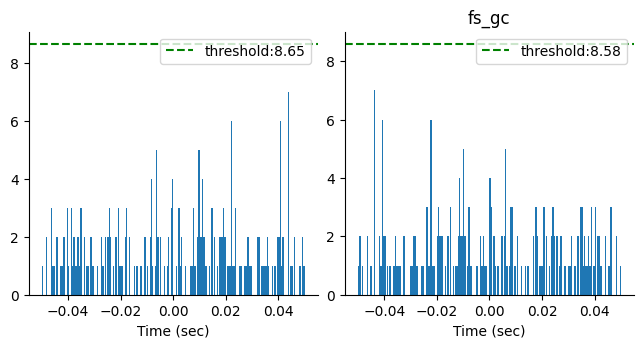

In [96]:
ncols= 5#len(inters)
nrows= 2
rowSize, colSize = 3,3

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)
bin_size_sec= 0.0005

sfs = Spike_train(name="sfs",sampling_rate=20000)
sfs.generate_poisson_spike_train(rate_hz=50, sampling_rate=20000, length_sec=2)
sgc = Spike_train(name="sgc",sampling_rate=20000)
sgc.generate_poisson_spike_train(rate_hz=25, sampling_rate=20000, length_sec=2)

## plot 

hist,edges= sgc.spike_time_crosscorrelation(st1=sgc.st, st2=sfs.st, bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
timestamp = sgc.mid_point_from_edges(edges)
#thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd=  6)
thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=6)
ax= fig.add_subplot(gs[0])
ax.bar(timestamp, hist, width= bin_size_sec)
ax.axhline(thr, color='g', linestyle='--', label='threshold:{:.2f}'.format(thr))
ax.set_xlabel('Time (sec)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()


hist,edges= sfs.spike_time_crosscorrelation(st2=sgc.st, st1=sfs.st, bin_size_sec=bin_size_sec, min_sec=-0.05, max_sec=0.05)
timestamp = sfs.mid_point_from_edges(edges)
#thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd=  6)
thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=6)
ax= fig.add_subplot(gs[1])
ax.bar(timestamp, hist, width= bin_size_sec)
ax.axhline(thr, color='g', linestyle='--', label='threshold:{:.2f}'.format(thr))
ax.set_title(f'fs_gc')
ax.set_xlabel('Time (sec)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

Test it on 2 real neurons 

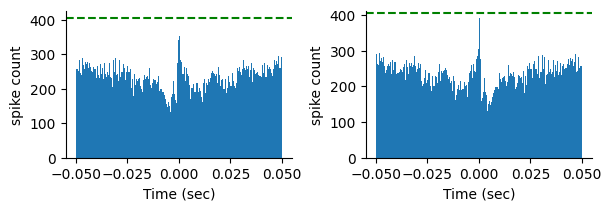

In [97]:
col, row = 2, 1
sizePerRow, sizePerCol = 2, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)


pair= (fsId,gcId)
bin_size_sec= 0.0005
width=0.005
timestd=  4

interName = 'circ80_1'
cc_cell_order= 'fs_gc'

ax= fig.add_subplot(gs[0])
plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= 0.0005, cc_cell_order= 'gc_fs', timestd= 5)

ax= fig.add_subplot(gs[1])
plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= 0.0005, cc_cell_order= 'fs_gc', timestd= 5)

So these 2 cells are not the connected fs cells 

## Get the pairs from one session 

In [69]:
def get_pairs_onesession(cells, sSes):
    # Filter cells by session
    session_cells = cells[(cells.session == sSes.name)]

    # Dictionary to keep track of the cluId pairs and their corresponding ids
    pair_dict = {
        'pair_type': [],  # 'same_shank' or 'other_shank'
        'fs_cluId': [],  # cluId of fs interneuron
        'gc_cluId': [],  # cluId of grid cell
        'hemisphere': [],
        'shank': []
    }

    # Loop through each unique hemisphere
    for hem in session_cells.cell_hemishphere.unique():
        print(f"Processing hemisphere: {hem}")

        # Loop through each unique shank
        for shank in session_cells.shank.unique():
            # Select cells from the same shank and hemisphere
            sameshank_cells = session_cells[(session_cells.shank == shank) & (session_cells.cell_hemishphere == hem)]
            othershank_cells = session_cells[~session_cells.cluId.isin(sameshank_cells.cluId)]
            
            # Find indices for interneurons (fs) and grid cells
            fsin_indx = np.where((sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1 > 10) )[0]
            gc_ssh_indx = np.where((sameshank_cells.gridCell_FIRST.values) )[0]
            gc_othsh_indx = np.where((othershank_cells.gridCell_FIRST.values) )[0]

            # Get the cluId for fs and grid cells (using indices)
            fsin_cluId = sameshank_cells[(sameshank_cells.interneuron) & (sameshank_cells.mrate_RF1> 10)].cluId.values
            gc_ssh_cluId = sameshank_cells[(sameshank_cells.gridCell_FIRST) &(~sameshank_cells.interneuron) ].cluId.values
            gc_othsh_cluId = othershank_cells[(othershank_cells.gridCell_FIRST) & (~othershank_cells.interneuron)].cluId.values

            # Generate pairs of indices for same-shank and other-shank
            pairs_sshank = list(product(fsin_cluId, gc_ssh_cluId)) # fs cells with grid cells on same shank
            pairs_Othshank =list(product(fsin_cluId, gc_othsh_cluId)) # fs cells with grid cells on other shanks

            # Store pair information in the dictionary (indices and cluId)
            for fsin_id, grid_id in pairs_sshank:
                pair_dict['pair_type'].append('same_shank')
                pair_dict['fs_cluId'].append(fsin_id)
                pair_dict['gc_cluId'].append(grid_id)
                pair_dict['hemisphere'].append(hem)
                pair_dict['shank'].append(shank)

            for fsin_id, grid_id in pairs_Othshank:
                pair_dict['pair_type'].append('other_shank')
                pair_dict['fs_cluId'].append(fsin_id)
                pair_dict['gc_cluId'].append(grid_id)
                pair_dict['hemisphere'].append(hem)
                pair_dict['shank'].append(shank)

    # Before creating the DataFrame, ensure all lists in pair_dict are of the same length
    min_length = min(len(pair_dict[key]) for key in pair_dict)
    for key in pair_dict:
        pair_dict[key] = pair_dict[key][:min_length]  # Truncate lists to the minimum length if necessary

    # Create a DataFrame from the pair dictionary
    pair_df = pd.DataFrame(pair_dict)

    # Return the DataFrame
    return pair_df


In [101]:
def get_connected_pairs_session(pair_df, sSes, interName='circ80_1', bin_size_sec= 0.0005,  timestd= 5, cc_cell_order= 'gc_fs'): 
    
    """
    Parameters:
    -----------
        - pair_df: DataFrame containing pairs of neurons to analyze, along with their metadata.
        - sSes: Session object from kilosort.
        - interName: Name of the interval used for cross-correlation analysis.
        - bin_size_sec: Bin size in seconds for the cross-correlation analysis.
        - timestd: To calculate the threshold on each session we have to criterias  
    
     Returns:
    -----------
    crossCorr_pairs_df: pd.DataFrame
        A DataFrame containing the following columns for all pairs:
        - 'pair_type': Type of pair ('same_shank' or 'other_shank').
        - 'fs_ind': Index of the interneuron.
        - 'gc_ind': Index of the grid cell.
        - 'fs_cluId': Cluster ID of the interneuron.
        - 'gc_cluId': Cluster ID of the grid cell.
        - 'hist': Cross-correlation histogram.
        - 'p1_time': Time of the first peak in the cross-correlation.
        - 'p1_height_zscore': Height of the first peak that is normalized .
        - 'connected': Boolean flag indicating whether the pair is 'connected' or not if we have a peak that has a heigher value than the threshold 
          
    """
    sshankdf= pair_df[pair_df.pair_type== 'same_shank']
    othshankdf= pair_df[pair_df.pair_type== 'other_shank']
    
    sshank_pairs=[]
    othshank_pairs=[]

    if sshankdf.shape[0]!= 0: 
        for ind,row in sshankdf.iterrows():
            pair= (row.fs_cluId, row.gc_cluId)
            timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= interName, bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
            #p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)
            #thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd)
            p1_time, p1_height_zscore= get_p1_FromCrossCorrPairs(hist, timestamp)
            thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=timestd)
            
            # Check if peak_times is non-empty and apply the condition for 'connected'
            #connected = not np.isnan(highest_peak_above_thr).all() and np.any(peak_times < 0.004) if interName == 'circ80_1' else False
            connected = (peak_time < 0.004) and (interName == 'circ80_1') and (not np.isnan(highest_peak_above_thr))
            sshank_pairs.append({
                'session': sSes.name,
                'interName': interName,
                'pair_type': 'same_shank',
                'fs_cluId':row.fs_cluId,
                'gc_cluId': row.gc_cluId,
                'hist': hist,
                'timestamp': timestamp,
                'p1_time': p1_time, 
                'p1_height_zscore': p1_height_zscore, 
                'peak_threshold': thr, 
                'highest_peak_above_thr': highest_peak_above_thr,
                'connected': connected
            })

    sshank_pairsdf= pd.DataFrame(sshank_pairs)

    if othshankdf.shape[0]!= 0: 
            for ind,row in othshankdf.iterrows():
                pair= (row.fs_cluId, row.gc_cluId)
                timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= interName, bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
                #p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)
                #thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd)
                p1_time, p1_height_zscore= get_p1_FromCrossCorrPairs(hist, timestamp)
                thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=timestd)

                # Check if peak_times is non-empty and apply the condition for 'connected'
                ## we have a threshold that is that has two condition 1. 5std of the baseline, and delay of < 4 ms 
                #connected = not np.isnan(highest_peak_above_thr).all() and np.any(peak_times < 0.004) if interName == 'circ80_1' else False
                connected = (peak_time < 0.004) and (interName == 'circ80_1') and (not np.isnan(highest_peak_above_thr))
                
                othshank_pairs.append({
                        'session': sSes.name,
                        'interName': interName,
                        'pair_type': 'other_shank',
                        'fs_cluId':row.fs_cluId,
                        'gc_cluId': row.gc_cluId,
                        'hist': hist,
                        'timestamp': timestamp,
                        'p1_time': p1_time, 
                        'p1_height_zscore': p1_height_zscore, 
                        'peak_threshold': thr, 
                        'highest_peak_above_thr': highest_peak_above_thr,
                        'connected': connected
                    })

    othshank_pairsdf= pd.DataFrame(othshank_pairs)
    crossCorr_pairs_df = pd.concat([sshank_pairsdf,othshank_pairsdf], ignore_index=True)
    
    return crossCorr_pairs_df

In [102]:
pair_df= get_pairs_onesession(cells, sSes)


Processing hemisphere: right
Processing hemisphere: left


In [103]:
pair_df

,pair_type,fs_cluId,gc_cluId,hemisphere,shank
0,same_shank,jp486-09032023-0108_945,jp486-09032023-0108_1060,right,1
1,same_shank,jp486-09032023-0108_945,jp486-09032023-0108_1104,right,1
2,same_shank,jp486-09032023-0108_945,jp486-09032023-0108_1180,right,1
3,same_shank,jp486-09032023-0108_1023,jp486-09032023-0108_1060,right,1
4,same_shank,jp486-09032023-0108_1023,jp486-09032023-0108_1104,right,1
...,...,...,...,...,...
261,other_shank,jp486-09032023-0108_537,jp486-09032023-0108_1371,left,0
262,other_shank,jp486-09032023-0108_537,jp486-09032023-0108_1375,left,0
263,other_shank,jp486-09032023-0108_537,jp486-09032023-0108_1403,left,0
264,other_shank,jp486-09032023-0108_537,jp486-09032023-0108_1427,left,0


In [104]:
sSes= sSessions[152]

pair_df = get_pairs_onesession(cells, sSes)
crossCorr_pairs_df = get_connected_pairs_session(pair_df, sSes, interName='circ80_1', bin_size_sec= 0.0005,  timestd= 5, cc_cell_order= 'gc_fs')
crossCorr_pairs_df.keys()

Processing hemisphere: right
Processing hemisphere: left


Index(['session', 'interName', 'pair_type', 'fs_cluId', 'gc_cluId', 'hist',
       'timestamp', 'p1_time', 'p1_height_zscore', 'peak_threshold',
       'highest_peak_above_thr', 'connected'],
      dtype='object')

In [105]:
# Safely convert 'peak_times' to floats based on its structure
crossCorr_pairs_df['p1_time'] = crossCorr_pairs_df['p1_time'].apply(
    lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else (np.nan if pd.isna(x) else float(x))
)

crossCorr_pairs_df[crossCorr_pairs_df.connected]

,session,interName,pair_type,fs_cluId,gc_cluId,hist,timestamp,p1_time,p1_height_zscore,peak_threshold,highest_peak_above_thr,connected
47,jp486-09032023-0108,circ80_1,same_shank,jp486-09032023-0108_1421,jp486-09032023-0108_1314,"[271.0, 235.0, 305.0, 288.0, 270.0, 265.0, 269...","[-0.04975, -0.04925, -0.04875, -0.04825, -0.04...",0.00025,5.229171,572.729410,586.0,True
69,jp486-09032023-0108,circ80_1,same_shank,jp486-09032023-0108_477,jp486-09032023-0108_483,"[96.0, 81.0, 98.0, 108.0, 91.0, 71.0, 92.0, 10...","[-0.04975, -0.04925, -0.04875, -0.04825, -0.04...",0.00075,10.237868,241.864263,388.0,True
202,jp486-09032023-0108,circ80_1,other_shank,jp486-09032023-0108_1421,jp486-09032023-0108_421,"[37.0, 38.0, 45.0, 33.0, 29.0, 36.0, 31.0, 38....","[-0.04975, -0.04925, -0.04875, -0.04825, -0.04...",0.00225,5.372642,70.346320,73.0,True


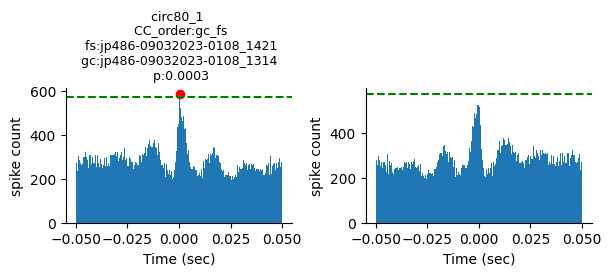

In [106]:
col, row = 2, 2
sizePerRow, sizePerCol = 2, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)


connecetd_df= crossCorr_pairs_df[crossCorr_pairs_df.connected== True]
pair= (connecetd_df.iloc[0]['fs_cluId'], connecetd_df.iloc[0]['gc_cluId'])


ax= fig.add_subplot(gs[0])
plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= 0.0005, cc_cell_order= 'gc_fs', timestd= 5)

ax= fig.add_subplot(gs[1])
plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= 0.0005, cc_cell_order= 'fs_gc', timestd= 5)

In [107]:
connecetd_df= crossCorr_pairs_df[crossCorr_pairs_df.connected== True].reset_index()

connecetd_df.shape

(3, 13)

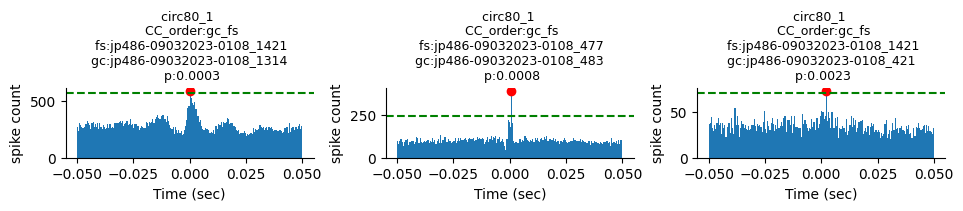

In [108]:
col, row = 4, 1
sizePerRow, sizePerCol = 2, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0)

bin_size_sec= 0.0005

for ind,row in connecetd_df.iterrows():
    gsi = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[ind], wspace=0.0)
    pair= (row['fs_cluId'], row['gc_cluId'])
    ax= fig.add_subplot(gs[ind])
    plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= bin_size_sec, cc_cell_order= 'gc_fs', timestd= 5)



## Get all the pairs for all the sessions and save them

In [113]:
sSes= sSessions[5]
sSes.name

'mn8578-10122021-0107'

In [114]:

pair_df = get_pairs_onesession(cells, sSes)
crossCorr_pairs_df = get_connected_pairs_session(pair_df, sSes, interName='circ80_1', bin_size_sec= 0.0005,  timestd= 5, cc_cell_order= 'gc_fs')
crossCorr_pairs_df.keys()

Processing hemisphere: right


Index(['session', 'interName', 'pair_type', 'fs_cluId', 'gc_cluId', 'hist',
       'timestamp', 'p1_time', 'p1_height_zscore', 'peak_threshold',
       'highest_peak_above_thr', 'connected'],
      dtype='object')

In [118]:
%%time
all_sessions=[]

interNames= ['circ80_1', 'searchPath_light', 'searchPath_dark', 
             'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark', 'atLever_light', 'atLever_dark']

for sSes in tqdm(sSessions[:]): 
    print(sSes.name)
    pair_df = get_pairs_onesession(cells, sSes)
    for interName in interNames: 
        crossCorr_pairs_df = get_connected_pairs_session(pair_df, sSes, interName=interName, bin_size_sec= 0.0005,  timestd= 5, cc_cell_order= 'gc_fs')
        all_sessions.append(crossCorr_pairs_df)

  0%|                                                                                                            | 0/180 [00:00<?, ?it/s]

mn8578-30112021-0107
Processing hemisphere: right
mn8578-05122021-0108
Processing hemisphere: right


  1%|█                                                                                                   | 2/180 [00:08<12:07,  4.09s/it]

mn8578-06122021-0107
Processing hemisphere: right


  2%|█▋                                                                                                  | 3/180 [00:14<15:17,  5.18s/it]

mn8578-07122021-0107
Processing hemisphere: right


  2%|██▏                                                                                                 | 4/180 [00:26<21:57,  7.49s/it]

mn8578-08122021-0110
Processing hemisphere: right


  3%|██▊                                                                                                 | 5/180 [00:48<36:33, 12.54s/it]

mn8578-10122021-0107
Processing hemisphere: right


  3%|███▎                                                                                                | 6/180 [00:56<32:28, 11.20s/it]

mn8578-15122021-0107
Processing hemisphere: right


  4%|███▊                                                                                              | 7/180 [01:47<1:09:03, 23.95s/it]

mn8578-17122021-0107
Processing hemisphere: right


  4%|████▎                                                                                             | 8/180 [02:17<1:13:40, 25.70s/it]

mn8578-23122021-0108
Processing hemisphere: right


  5%|████▉                                                                                             | 9/180 [04:10<2:30:20, 52.75s/it]

mn8578-27122021-0107
Processing hemisphere: right


  6%|█████▍                                                                                           | 10/180 [04:24<1:55:47, 40.87s/it]

mn8578-25122021-0107
Processing hemisphere: right


  6%|█████▉                                                                                           | 11/180 [05:03<1:53:43, 40.38s/it]

mn8578-28122021-0107
Processing hemisphere: right


  7%|██████▍                                                                                          | 12/180 [05:15<1:29:10, 31.85s/it]

mn8578-29122021-0107
Processing hemisphere: right


  7%|███████                                                                                          | 13/180 [05:23<1:08:52, 24.75s/it]

mn8578-03012022-0107
Processing hemisphere: right


  8%|███████▋                                                                                           | 14/180 [05:29<52:02, 18.81s/it]

mn8599-18012022-0107
Processing hemisphere: right
mn8599-19012022-0107
Processing hemisphere: right
mn8599-22012022-0108
Processing hemisphere: right
mn8599-20012022-0107
Processing hemisphere: right


 10%|█████████▉                                                                                         | 18/180 [05:50<27:52, 10.32s/it]

mn8599-25012022-0107
Processing hemisphere: right
mn8599-26012022-0107
Processing hemisphere: right


 11%|███████████                                                                                        | 20/180 [05:54<20:34,  7.72s/it]

mn8599-27012022-0107
Processing hemisphere: right


 12%|███████████▌                                                                                       | 21/180 [06:03<20:49,  7.86s/it]

mn8599-28012022-0107
Processing hemisphere: right


 12%|████████████                                                                                       | 22/180 [06:07<18:38,  7.08s/it]

mn8599-01022022-0108
Processing hemisphere: right


 13%|████████████▋                                                                                      | 23/180 [06:10<16:33,  6.33s/it]

mn8599-02022022-0107
Processing hemisphere: right


 13%|█████████████▏                                                                                     | 24/180 [06:32<25:55,  9.97s/it]

mn8599-03022022-0107
Processing hemisphere: right


 14%|█████████████▊                                                                                     | 25/180 [06:41<25:43,  9.96s/it]

mn8599-04022022-0107
Processing hemisphere: right


 14%|██████████████▎                                                                                    | 26/180 [06:49<23:54,  9.31s/it]

mn8599-08022022-0107
Processing hemisphere: right


 15%|██████████████▊                                                                                    | 27/180 [06:50<18:02,  7.08s/it]

mn8599-09022022-0107
Processing hemisphere: right


 16%|███████████████▍                                                                                   | 28/180 [07:07<24:40,  9.74s/it]

mn8599-10022022-0107
Processing hemisphere: right


 16%|███████████████▉                                                                                   | 29/180 [07:27<32:15, 12.82s/it]

mn8599-11022022-0107
Processing hemisphere: right


 17%|████████████████▌                                                                                  | 30/180 [08:05<50:01, 20.01s/it]

mn8599-12022022-0107
Processing hemisphere: right
mn8599-14022022-0106
Processing hemisphere: right


 18%|█████████████████▌                                                                                 | 32/180 [08:08<28:43, 11.65s/it]

mn8599-15022022-0107
Processing hemisphere: right


 18%|██████████████████▏                                                                                | 33/180 [08:17<26:51, 10.96s/it]

mn8599-16022022-0107
Processing hemisphere: right


 19%|██████████████████▋                                                                                | 34/180 [08:30<28:16, 11.62s/it]

jp1084-14042022-0108
Processing hemisphere: right


 19%|███████████████████▎                                                                               | 35/180 [08:33<22:19,  9.24s/it]

jp1084-13042022-0108
Processing hemisphere: right


 20%|███████████████████▊                                                                               | 36/180 [08:38<19:23,  8.08s/it]

jp1084-12042022-0108
Processing hemisphere: right
jp1084-11042022-0107
Processing hemisphere: right
jp1084-09042022-0107
Processing hemisphere: right


 22%|█████████████████████▍                                                                             | 39/180 [08:39<09:13,  3.92s/it]

jp1084-08042022-0107
Processing hemisphere: right


 22%|██████████████████████                                                                             | 40/180 [08:41<08:15,  3.54s/it]

jp1084-06042022-0107
Processing hemisphere: right


 23%|██████████████████████▌                                                                            | 41/180 [08:50<10:36,  4.58s/it]

jp1084-07042022-0107
Processing hemisphere: right


 23%|███████████████████████                                                                            | 42/180 [09:05<16:35,  7.21s/it]

jp1084-03042022-0107
Processing hemisphere: right


 24%|███████████████████████▋                                                                           | 43/180 [09:10<15:15,  6.68s/it]

jp1084-04042022-0107
Processing hemisphere: right


 24%|████████████████████████▏                                                                          | 44/180 [09:18<15:41,  6.93s/it]

jp1084-05042022-0107
Processing hemisphere: right


 26%|█████████████████████████▊                                                                         | 47/180 [09:41<14:14,  6.42s/it]

jp1685-23042022-0108
Processing hemisphere: right
jp1685-24042022-0108
Processing hemisphere: right
jp1685-28042022-0108
Processing hemisphere: right


 27%|██████████████████████████▍                                                                        | 48/180 [09:45<12:42,  5.78s/it]

jp1685-29042022-0108
Processing hemisphere: right


 27%|██████████████████████████▉                                                                        | 49/180 [09:50<12:06,  5.55s/it]

jp1685-27042022-0108
Processing hemisphere: right
jp1685-26042022-0108
Processing hemisphere: right
jp1685-25042022-0108
Processing hemisphere: right
jp1687-26052022-0107
Processing hemisphere: right


 29%|█████████████████████████████▏                                                                     | 53/180 [10:09<10:42,  5.06s/it]

jp1687-25052022-0107
Processing hemisphere: right


 30%|█████████████████████████████▋                                                                     | 54/180 [10:15<11:09,  5.31s/it]

jp1687-24052022-0108
Processing hemisphere: right


 31%|██████████████████████████████▎                                                                    | 55/180 [10:16<09:18,  4.47s/it]

jp1687-23052022-0108
Processing hemisphere: right
jp3130-28052022-0107
Processing hemisphere: right
jp3130-27052022-0106
Processing hemisphere: right


 32%|███████████████████████████████▉                                                                   | 58/180 [10:20<06:12,  3.05s/it]

jp3130-26052022-0107
Processing hemisphere: right


 33%|████████████████████████████████▍                                                                  | 59/180 [10:59<19:03,  9.45s/it]

jp1684-13052022-0107
Processing hemisphere: right


 33%|█████████████████████████████████                                                                  | 60/180 [11:00<15:35,  7.80s/it]

jp1684-14052022-0107
Processing hemisphere: right


 34%|█████████████████████████████████▌                                                                 | 61/180 [11:03<13:20,  6.72s/it]

jp1684-15052022-0107
Processing hemisphere: right


 34%|██████████████████████████████████                                                                 | 62/180 [11:19<17:28,  8.88s/it]

jp1684-16052022-0107
Processing hemisphere: right
jp1686-21042022-0107
Processing hemisphere: right


 36%|███████████████████████████████████▏                                                               | 64/180 [11:20<10:21,  5.36s/it]

jp1686-22042022-0107
Processing hemisphere: right


 36%|███████████████████████████████████▊                                                               | 65/180 [11:26<10:44,  5.61s/it]

jp1686-24042022-0107
Processing hemisphere: right


 37%|████████████████████████████████████▎                                                              | 66/180 [11:31<10:34,  5.57s/it]

jp1686-25042022-0107
Processing hemisphere: right
jp1686-26042022-0108
Processing hemisphere: right


 38%|█████████████████████████████████████▍                                                             | 68/180 [11:53<14:22,  7.70s/it]

jp1686-27042022-0107
Processing hemisphere: right


 38%|█████████████████████████████████████▉                                                             | 69/180 [12:28<25:52, 13.98s/it]

jp1686-28042022-0107
Processing hemisphere: right


 39%|██████████████████████████████████████▌                                                            | 70/180 [12:58<32:44, 17.86s/it]

jp1686-29042022-0109
Processing hemisphere: right


 39%|███████████████████████████████████████                                                            | 71/180 [13:08<28:53, 15.90s/it]

jp3120-15052022-0107
Processing hemisphere: right
jp3120-16052022-0107
Processing hemisphere: right
jp3120-17052022-0107
Processing hemisphere: right
jp3120-18052022-0108
Processing hemisphere: right
jp3120-19052022-0107
Processing hemisphere: right
jp3120-23052022-0108
Processing hemisphere: right


 43%|██████████████████████████████████████████▎                                                        | 77/180 [13:16<10:03,  5.86s/it]

jp3120-24052022-0108
Processing hemisphere: right


 43%|██████████████████████████████████████████▉                                                        | 78/180 [14:10<21:20, 12.56s/it]

jp3120-25052022-0107
Processing hemisphere: right


 44%|███████████████████████████████████████████▍                                                       | 79/180 [15:42<43:35, 25.89s/it]

jp3120-26052022-0107
Processing hemisphere: right


 44%|████████████████████████████████████████████                                                       | 80/180 [15:58<40:06, 24.06s/it]

jp3120-27052022-0110
Processing hemisphere: right
jp3129-02062022-0108
Processing hemisphere: right
jp3129-03062022-0108
Processing hemisphere: right


 46%|█████████████████████████████████████████████▋                                                     | 83/180 [16:24<27:29, 17.00s/it]

jp3129-04062022-0108
Processing hemisphere: right


 47%|██████████████████████████████████████████████▏                                                    | 84/180 [17:02<33:17, 20.81s/it]

jp3129-05062022-0108
Processing hemisphere: right
jp3129-06062022-0107
Processing hemisphere: right


 48%|███████████████████████████████████████████████▎                                                   | 86/180 [17:33<29:38, 18.92s/it]

jp3129-07062022-0107
Processing hemisphere: right


 48%|███████████████████████████████████████████████▊                                                   | 87/180 [17:38<25:10, 16.24s/it]

jp3129-08062022-0108
Processing hemisphere: right
jp3129-09062022-0108
Processing hemisphere: right
jp3129-10062022-0107
Processing hemisphere: right


 50%|█████████████████████████████████████████████████▌                                                 | 90/180 [17:45<14:55,  9.95s/it]

jp451-05112022-0110
Processing hemisphere: right
jp451-28102022-0108
Processing hemisphere: right


 51%|██████████████████████████████████████████████████▌                                                | 92/180 [18:26<19:23, 13.22s/it]

jp451-21102022-0108
Processing hemisphere: right
jp451-22102022-0108
Processing hemisphere: right
jp451-26102022-0108
Processing hemisphere: right
jp451-03112022-0108
Processing hemisphere: right
jp451-30102022-0108
Processing hemisphere: right
jp451-27102022-0108
Processing hemisphere: right


 54%|█████████████████████████████████████████████████████▉                                             | 98/180 [18:37<09:15,  6.77s/it]

jp451-24102022-0108
Processing hemisphere: right


 55%|██████████████████████████████████████████████████████▍                                            | 99/180 [18:37<08:06,  6.00s/it]

jp451-01112022-0108
Processing hemisphere: right
jp451-29102022-0108
Processing hemisphere: right
jp451-04112022-0108
Processing hemisphere: right
jp451-23102022-0108
Processing hemisphere: right
jp451-25102022-0108
Processing hemisphere: right
jp452-18112022-0108
Processing hemisphere: right
jp452-08112022-0108
Processing hemisphere: right
jp452-09112022-0108
Processing hemisphere: right
jp452-25112022-0110
Processing hemisphere: right


 60%|██████████████████████████████████████████████████████████▊                                       | 108/180 [19:24<06:38,  5.54s/it]

jp452-23112022-0108
Processing hemisphere: right


 61%|███████████████████████████████████████████████████████████▎                                      | 109/180 [19:30<06:35,  5.57s/it]

jp452-21112022-0108
Processing hemisphere: right
jp452-11112022-0109
Processing hemisphere: right
jp452-19112022-0108
Processing hemisphere: right


 62%|████████████████████████████████████████████████████████████▉                                     | 112/180 [19:55<07:07,  6.29s/it]

jp452-16112022-0108
Processing hemisphere: right


 63%|█████████████████████████████████████████████████████████████▌                                    | 113/180 [19:56<06:20,  5.68s/it]

jp452-22112022-0108
Processing hemisphere: right


 63%|██████████████████████████████████████████████████████████████                                    | 114/180 [20:02<06:14,  5.67s/it]

jp452-14112022-0108
Processing hemisphere: right


 64%|██████████████████████████████████████████████████████████████▌                                   | 115/180 [20:02<05:12,  4.81s/it]

jp452-13112022-0108
Processing hemisphere: right
jp452-24112022-0109
Processing hemisphere: right


 65%|███████████████████████████████████████████████████████████████▋                                  | 117/180 [20:36<09:06,  8.68s/it]

jp452-15112022-0108
Processing hemisphere: right
jp452-12112022-0109
Processing hemisphere: right
jp452-17112022-0108
Processing hemisphere: right
jp3269-24112022-0108
Processing hemisphere: right
jp3269-29112022-0108
Processing hemisphere: right


 68%|██████████████████████████████████████████████████████████████████▍                               | 122/180 [23:16<20:32, 21.24s/it]

jp3269-28112022-0108
Processing hemisphere: right


 68%|██████████████████████████████████████████████████████████████████▉                               | 123/180 [25:49<36:44, 38.68s/it]

jp3269-27112022-0108
Processing hemisphere: right


 69%|███████████████████████████████████████████████████████████████████▌                              | 124/180 [26:10<33:33, 35.96s/it]

jp3269-30112022-0110
Processing hemisphere: right


 69%|████████████████████████████████████████████████████████████████████                              | 125/180 [26:47<33:08, 36.15s/it]

jp3269-25112022-0108
Processing hemisphere: right
jp3269-23112022-0108
Processing hemisphere: right
jp3269-26112022-0108
Processing hemisphere: right


 71%|█████████████████████████████████████████████████████████████████████▋                            | 128/180 [27:22<21:55, 25.30s/it]

jp486-14032023-0108
Processing hemisphere: left
Processing hemisphere: right
jp486-27032023-0110
Processing hemisphere: left
Processing hemisphere: right


 72%|██████████████████████████████████████████████████████████████████████▊                           | 130/180 [27:56<19:01, 22.84s/it]

jp486-20032023-0108
Processing hemisphere: right
Processing hemisphere: left


 73%|███████████████████████████████████████████████████████████████████████▎                          | 131/180 [32:37<55:31, 67.99s/it]

jp486-15032023-0108
Processing hemisphere: right
Processing hemisphere: left


 73%|█████████████████████████████████████████████████████████████████████▋                         | 132/180 [38:20<1:38:24, 123.00s/it]

jp486-13032023-0108
Processing hemisphere: right
Processing hemisphere: left


 74%|██████████████████████████████████████████████████████████████████████▏                        | 133/180 [43:31<2:09:00, 164.68s/it]

jp486-16032023-0108
Processing hemisphere: left
Processing hemisphere: right


 74%|██████████████████████████████████████████████████████████████████████▋                        | 134/180 [49:35<2:43:08, 212.78s/it]

jp486-26032023-0108
Processing hemisphere: left
Processing hemisphere: right


 75%|███████████████████████████████████████████████████████████████████████▎                       | 135/180 [50:20<2:07:18, 169.75s/it]

jp486-18032023-0108
Processing hemisphere: left
Processing hemisphere: right


 76%|███████████████████████████████████████████████████████████████████████▊                       | 136/180 [58:13<3:04:05, 251.03s/it]

jp486-22032023-0108
Processing hemisphere: left
Processing hemisphere: right


 76%|██████████████████████████████████████████████████████████████████████▊                      | 137/180 [1:02:34<3:01:44, 253.59s/it]

jp486-24032023-0108
Processing hemisphere: left
Processing hemisphere: right


 77%|███████████████████████████████████████████████████████████████████████▎                     | 138/180 [1:03:01<2:12:39, 189.51s/it]

jp486-03032023-0108
Processing hemisphere: right
Processing hemisphere: left


 77%|███████████████████████████████████████████████████████████████████████▊                     | 139/180 [1:05:24<2:00:17, 176.05s/it]

jp486-07032023-0108
Processing hemisphere: left
Processing hemisphere: right
jp486-19032023-0108
Processing hemisphere: left
Processing hemisphere: right


 78%|████████████████████████████████████████████████████████████████████████▊                    | 141/180 [1:09:31<1:38:59, 152.30s/it]

jp486-28022023-0108
Processing hemisphere: left
jp486-10032023-0108
Processing hemisphere: left
Processing hemisphere: right


 79%|█████████████████████████████████████████████████████████████████████████▉                   | 143/180 [1:13:29<1:25:50, 139.20s/it]

jp486-06032023-0108
Processing hemisphere: right
Processing hemisphere: left


 80%|██████████████████████████████████████████████████████████████████████████▍                  | 144/180 [1:16:34<1:29:38, 149.41s/it]

jp486-26022023-0108
Processing hemisphere: left
Processing hemisphere: right


 81%|██████████████████████████████████████████████████████████████████████████▉                  | 145/180 [1:16:41<1:07:21, 115.47s/it]

jp486-27022023-0108
Processing hemisphere: left
Processing hemisphere: right


 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 146/180 [1:16:59<51:25, 90.76s/it]

jp486-01032023-0108
Processing hemisphere: right
Processing hemisphere: left
jp486-17032023-0108
Processing hemisphere: left
Processing hemisphere: right


 82%|██████████████████████████████████████████████████████████████████████████████▉                 | 148/180 [1:20:35<52:16, 98.00s/it]

jp486-02032023-0108
Processing hemisphere: left
Processing hemisphere: right


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 149/180 [1:23:04<56:43, 109.78s/it]

jp486-05032023-0108
Processing hemisphere: right
Processing hemisphere: left


 83%|█████████████████████████████████████████████████████████████████████████████▌               | 150/180 [1:28:38<1:22:35, 165.18s/it]

jp486-25032023-0108
Processing hemisphere: left
Processing hemisphere: right
jp486-25022023-0108
Processing hemisphere: left
Processing hemisphere: right
jp486-09032023-0108
Processing hemisphere: right
Processing hemisphere: left


 85%|███████████████████████████████████████████████████████████████████████████████              | 153/180 [1:38:31<1:21:53, 181.97s/it]

jp487-05022023-0108
Processing hemisphere: left
Processing hemisphere: right


 86%|███████████████████████████████████████████████████████████████████████████████▌             | 154/180 [1:38:34<1:03:36, 146.78s/it]

jp487-09022023-0108
Processing hemisphere: left
Processing hemisphere: right
jp487-10022023-0108
Processing hemisphere: left
Processing hemisphere: right


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 156/180 [1:38:37<37:46, 94.44s/it]

jp487-07022023-0108
Processing hemisphere: right
Processing hemisphere: left
jp487-12022023-0108
Processing hemisphere: left
Processing hemisphere: right
jp487-06022023-0108
Processing hemisphere: left
Processing hemisphere: right


 92%|████████████████████████████████████████████████████████████████████████████████████████        | 165/180 [1:38:41<06:00, 24.01s/it]

jp497-09052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-06052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-11052023-0110
Processing hemisphere: right
Processing hemisphere: left
jp497-04052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-03052023-0108
Processing hemisphere: right
jp497-05052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-02052023-0109
Processing hemisphere: left
Processing hemisphere: right
jp497-30042023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-07052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-10052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp497-08052023-0108
Processing hemisphere: left
Processing hemisphere: right


 94%|██████████████████████████████████████████████████████████████████████████████████████████▋     | 170/180 [1:38:44<02:26, 14.65s/it]

jp499-15052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp499-22052023-0108
Processing hemisphere: right
Processing hemisphere: left


 96%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 172/180 [1:38:47<01:38, 12.29s/it]

jp499-19052023-0108
Processing hemisphere: left
Processing hemisphere: right


 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 173/180 [1:38:49<01:17, 11.08s/it]

jp499-26052023-0110
Processing hemisphere: left
Processing hemisphere: right
jp499-17052023-0108
Processing hemisphere: right
Processing hemisphere: left
jp499-23052023-0108
Processing hemisphere: left
Processing hemisphere: right
jp499-24052023-0108
Processing hemisphere: right
Processing hemisphere: left
jp499-16052023-0108
Processing hemisphere: right
jp499-18052023-0108
Processing hemisphere: left
Processing hemisphere: right


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▍| 179/180 [1:38:59<00:06,  6.33s/it]

jp499-25052023-0108
Processing hemisphere: left
Processing hemisphere: right


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [1:39:11<00:00, 33.06s/it]

CPU times: user 1h 23min 34s, sys: 15min 17s, total: 1h 38min 51s
Wall time: 1h 39min 11s


sanity check 

In [123]:
len(all_sessions), len(sSessions)*7

(1260, 1260)

In [121]:
crossCorr_pairs_allsessions_df= pd.concat(all_sessions)
connecteddf= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.interName== 'circ80_1')&(crossCorr_pairs_allsessions_df.connected==True)].reset_index()
notconnected_df= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.interName== 'circ80_1')&(crossCorr_pairs_allsessions_df.connected== False)].reset_index()

In [124]:
fn= 'crossCorr_pairs_allsessions_df.pkl'
crossCorr_pairs_allsessions_df.to_pickle(fn)

In [138]:
connecteddf.shape, connecteddf.keys()


((519, 13),
 Index(['index', 'session', 'interName', 'pair_type', 'fs_cluId', 'gc_cluId',
        'hist', 'timestamp', 'p1_time', 'p1_height_zscore', 'peak_threshold',
        'highest_peak_above_thr', 'connected'],
       dtype='object'))

Text(0, 0.5, 'pairs')

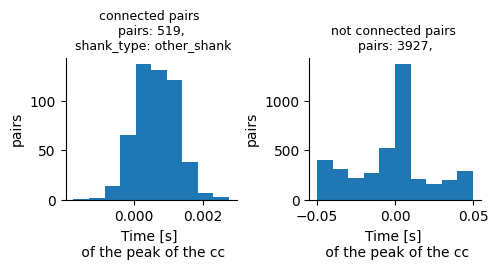

In [139]:
import itertools

ncols= 5#len(inters)
nrows= 2
rowSize, colSize = 2,2

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

ax= fig.add_subplot(gs[0])
peakheights= list(connecteddf.highest_peak_above_thr)
#peakheights = list(itertools.chain(*peakheights))

peaktimes= list(connecteddf.p1_time)
#peaktimes= list(itertools.chain(*peaktime))

plt.hist(peaktimes, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'connected pairs \n pairs: {connecteddf.shape[0]}, \n shank_type: {connecteddf.pair_type.unique()[0]}', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')

ax= fig.add_subplot(gs[1])
plt.hist(notconnected_df.p1_time, bins=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'not connected pairs \n pairs: {notconnected_df.shape[0]}, ', fontsize= 9)
ax.set_xlabel('Time [s] \n of the peak of the cc')
ax.set_ylabel('pairs')

## Plot some example of time of Cross correlation of connecetd cells

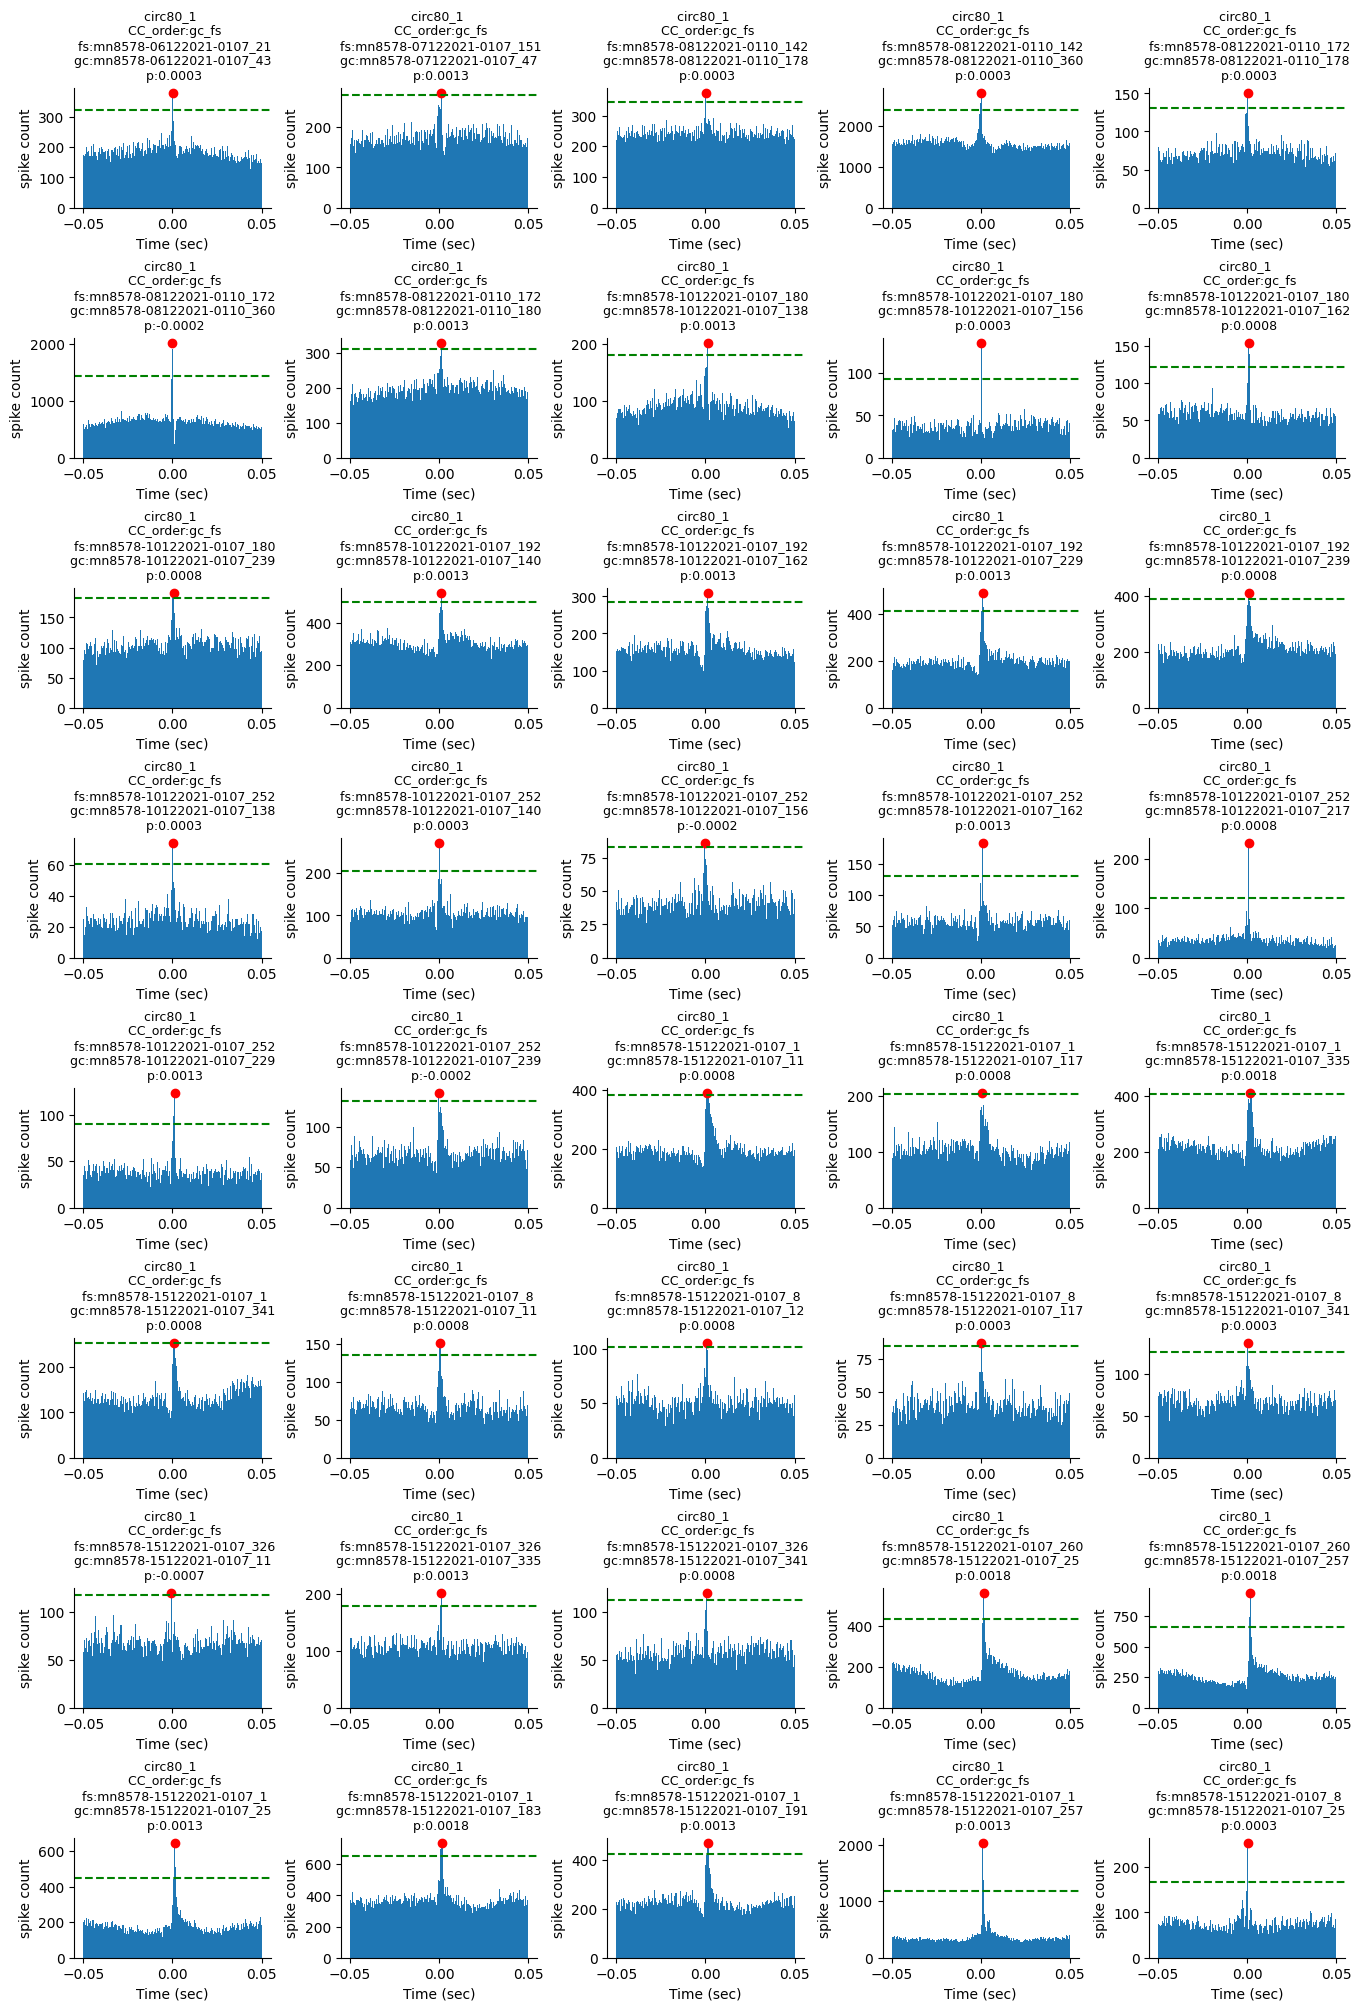

In [128]:
ncols= 5#len(inters)
nrows= 8
rowSize, colSize = 2.5,2.7

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)


for ind,row in connecteddf.iloc[:40].iterrows():
    #print(ind)
    pair= (row.fs_cluId, row.gc_cluId)
    timestamp, hist= get_crossCorrPairs_interval(sSes, pair, interName= interName, bin_size_sec= bin_size_sec, cc_cell_order= cc_cell_order)
    p1_time, p1_height= get_p1_FromCrossCorrPairs(hist, timestamp)
    #thr, peaks_heights_above_thr, peak_times  = find_peaks_higher_than_threshold(hist, timestamp, timestd)
    thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=6)
    ax= fig.add_subplot(gs[ind])
    plot_crossCorr_pairs(ax, pair, interName= 'circ80_1',bin_size_sec= bin_size_sec, cc_cell_order= 'gc_fs', timestd= 5)


In [129]:
fn= 'df_peak_crosscorr_all.csv'
crossCorr_pairs_allsessions_df.to_csv(fn , index=False)

In [130]:
## load the af_all_sessions
fn= 'df_peak_crosscorr_all.csv'
crossCorr_pairs_allsessions_df =  pd.read_csv(fn)

### Get the peak change of the cells that are connected togehter vs the cells that are not connected from RF to the atLeverlight or atLeverDark  

In [15]:
crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected)].reset_index()

,index,session,interName,pair_type,fs_cluId,gc_cluId,hist,timestamp,p1_time,p1_height,peak_threshold,peaks_heights_above_thr,peak_times,connected
0,51,mn8578-06122021-0107,circ80_1,same_shank,mn8578-06122021-0107_21,mn8578-06122021-0107_43,[173. 171. 176. 201. 183. 187. 172. 161. 172. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,377.0,323.675644,[377.],[0.00025],True
1,94,mn8578-07122021-0107,circ80_1,same_shank,mn8578-07122021-0107_151,mn8578-07122021-0107_47,[158. 172. 194. 193. 154. 167. 136. 168. 165. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00125,284.0,279.460849,[284.],[0.00125],True
2,135,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_142,mn8578-08122021-0110_178,[221. 250. 235. 262. 232. 230. 228. 252. 229. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,372.0,343.277809,[372.],[0.00025],True
3,136,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_142,mn8578-08122021-0110_360,[1555. 1564. 1610. 1656. 1523. 1613. 1569. 168...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,2799.0,2398.415818,[2799.],[0.00025],True
4,137,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_172,mn8578-08122021-0110_178,[ 80. 74. 62. 60. 63. 69. 72. 67. 67. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,150.0,130.307949,[150.],[0.00025],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,30932,jp497-08052023-0108,homingFromLeavingLeverToPeriphery_light,same_shank,jp497-08052023-0108_224,jp497-08052023-0108_169,[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,-0.00975,3.0,2.721707,[3.],[-0.00975],True
1029,30949,jp499-22052023-0108,circ80_1,same_shank,jp499-22052023-0108_448,jp499-22052023-0108_556,[ 44. 44. 44. 46. 37. 46. 45. 55. 44. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00175,131.0,116.580730,[131.],[0.00175],True
1030,30950,jp499-22052023-0108,circ80_1,same_shank,jp499-22052023-0108_552,jp499-22052023-0108_556,[ 129. 105. 109. 117. 122. 137. 115. 13...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00075,1196.0,539.852920,[1196.],[0.00075],True
1031,30998,jp499-18052023-0108,circ80_1,same_shank,jp499-18052023-0108_741,jp499-18052023-0108_743,[ 37. 29. 19. 37. 40. 40. 29. 30. 33. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00075,239.0,116.000796,[239.],[0.00075],True


In [19]:
#np.array(crossCorr_pairs_allsessions_df['hist'].values)

In [20]:
crossCorr_pairs_allsessions_df.keys()

import ast

# Convert string representations of lists to actual lists, then extract the first element as a float
def convert_peak_times(x):
    if isinstance(x, str):
        try:
            # Convert string representation to an actual list
            x = ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return np.nan  # Return NaN if conversion fails
    if isinstance(x, (list, np.ndarray)) and len(x) > 0:
        return float(x[0])
    return np.nan  # Return NaN if it's not a valid list or empty

In [21]:
connected= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected)].reset_index()
notconnected= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected== False)].reset_index()

connected['peak_times'] = connected['peak_times'].apply(convert_peak_times)
connected['peaks_heights_above_thr'] = connected['peaks_heights_above_thr'].apply(convert_peak_times)


In [22]:
connected

,index,session,interName,pair_type,fs_cluId,gc_cluId,hist,timestamp,p1_time,p1_height,peak_threshold,peaks_heights_above_thr,peak_times,connected
0,51,mn8578-06122021-0107,circ80_1,same_shank,mn8578-06122021-0107_21,mn8578-06122021-0107_43,[173. 171. 176. 201. 183. 187. 172. 161. 172. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,377.0,323.675644,377.0,0.00025,True
1,94,mn8578-07122021-0107,circ80_1,same_shank,mn8578-07122021-0107_151,mn8578-07122021-0107_47,[158. 172. 194. 193. 154. 167. 136. 168. 165. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00125,284.0,279.460849,284.0,0.00125,True
2,135,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_142,mn8578-08122021-0110_178,[221. 250. 235. 262. 232. 230. 228. 252. 229. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,372.0,343.277809,372.0,0.00025,True
3,136,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_142,mn8578-08122021-0110_360,[1555. 1564. 1610. 1656. 1523. 1613. 1569. 168...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,2799.0,2398.415818,2799.0,0.00025,True
4,137,mn8578-08122021-0110,circ80_1,same_shank,mn8578-08122021-0110_172,mn8578-08122021-0110_178,[ 80. 74. 62. 60. 63. 69. 72. 67. 67. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00025,150.0,130.307949,150.0,0.00025,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,30932,jp497-08052023-0108,homingFromLeavingLeverToPeriphery_light,same_shank,jp497-08052023-0108_224,jp497-08052023-0108_169,[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,-0.00975,3.0,2.721707,3.0,-0.00975,True
1029,30949,jp499-22052023-0108,circ80_1,same_shank,jp499-22052023-0108_448,jp499-22052023-0108_556,[ 44. 44. 44. 46. 37. 46. 45. 55. 44. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00175,131.0,116.580730,131.0,0.00175,True
1030,30950,jp499-22052023-0108,circ80_1,same_shank,jp499-22052023-0108_552,jp499-22052023-0108_556,[ 129. 105. 109. 117. 122. 137. 115. 13...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00075,1196.0,539.852920,1196.0,0.00075,True
1031,30998,jp499-18052023-0108,circ80_1,same_shank,jp499-18052023-0108_741,jp499-18052023-0108_743,[ 37. 29. 19. 37. 40. 40. 29. 30. 33. ...,[-0.04975 -0.04925 -0.04875 -0.04825 -0.04775 ...,0.00075,239.0,116.000796,239.0,0.00075,True


Text(0.5, 1.0, 'not connected pairs')

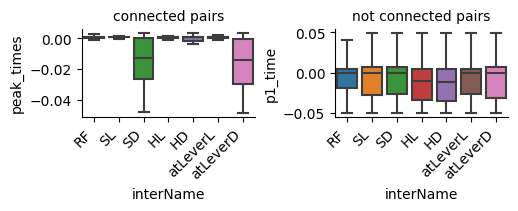

In [131]:
# Plot settings
col = 6
row = 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

ax= fig.add_subplot(gs[0])
sns.boxplot(data=connected, x='interName' , y='peak_times', dodge=True, showfliers=False, ax= ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xlim(-0.1,0.1)
xlabs= ['RF', 'SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']

ax.set_xticklabels(xlabs, rotation=45, ha='right')
ax.set_title('connected pairs', fontsize=10)


ax= fig.add_subplot(gs[1])
sns.boxplot(data=notconnected, x='interName' , y='p1_time', dodge=True, showfliers=False, ax= ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xlim(-0.1,0.1)
xlabs= ['RF', 'SL', 'SD', 'HL', 'HD', 'atLeverL', 'atLeverD']
ax.set_xticklabels(xlabs, rotation=45, ha='right')
ax.set_title('not connected pairs', fontsize=10)



In [139]:
connected.keys(), timestd

(Index(['index', 'session', 'interName', 'pair_type', 'fs_cluId', 'gc_cluId',
        'hist', 'timestamp', 'p1_time', 'p1_height', 'peak_threshold',
        'peaks_heights_above_thr', 'peak_times', 'connected'],
       dtype='object'),
 4)

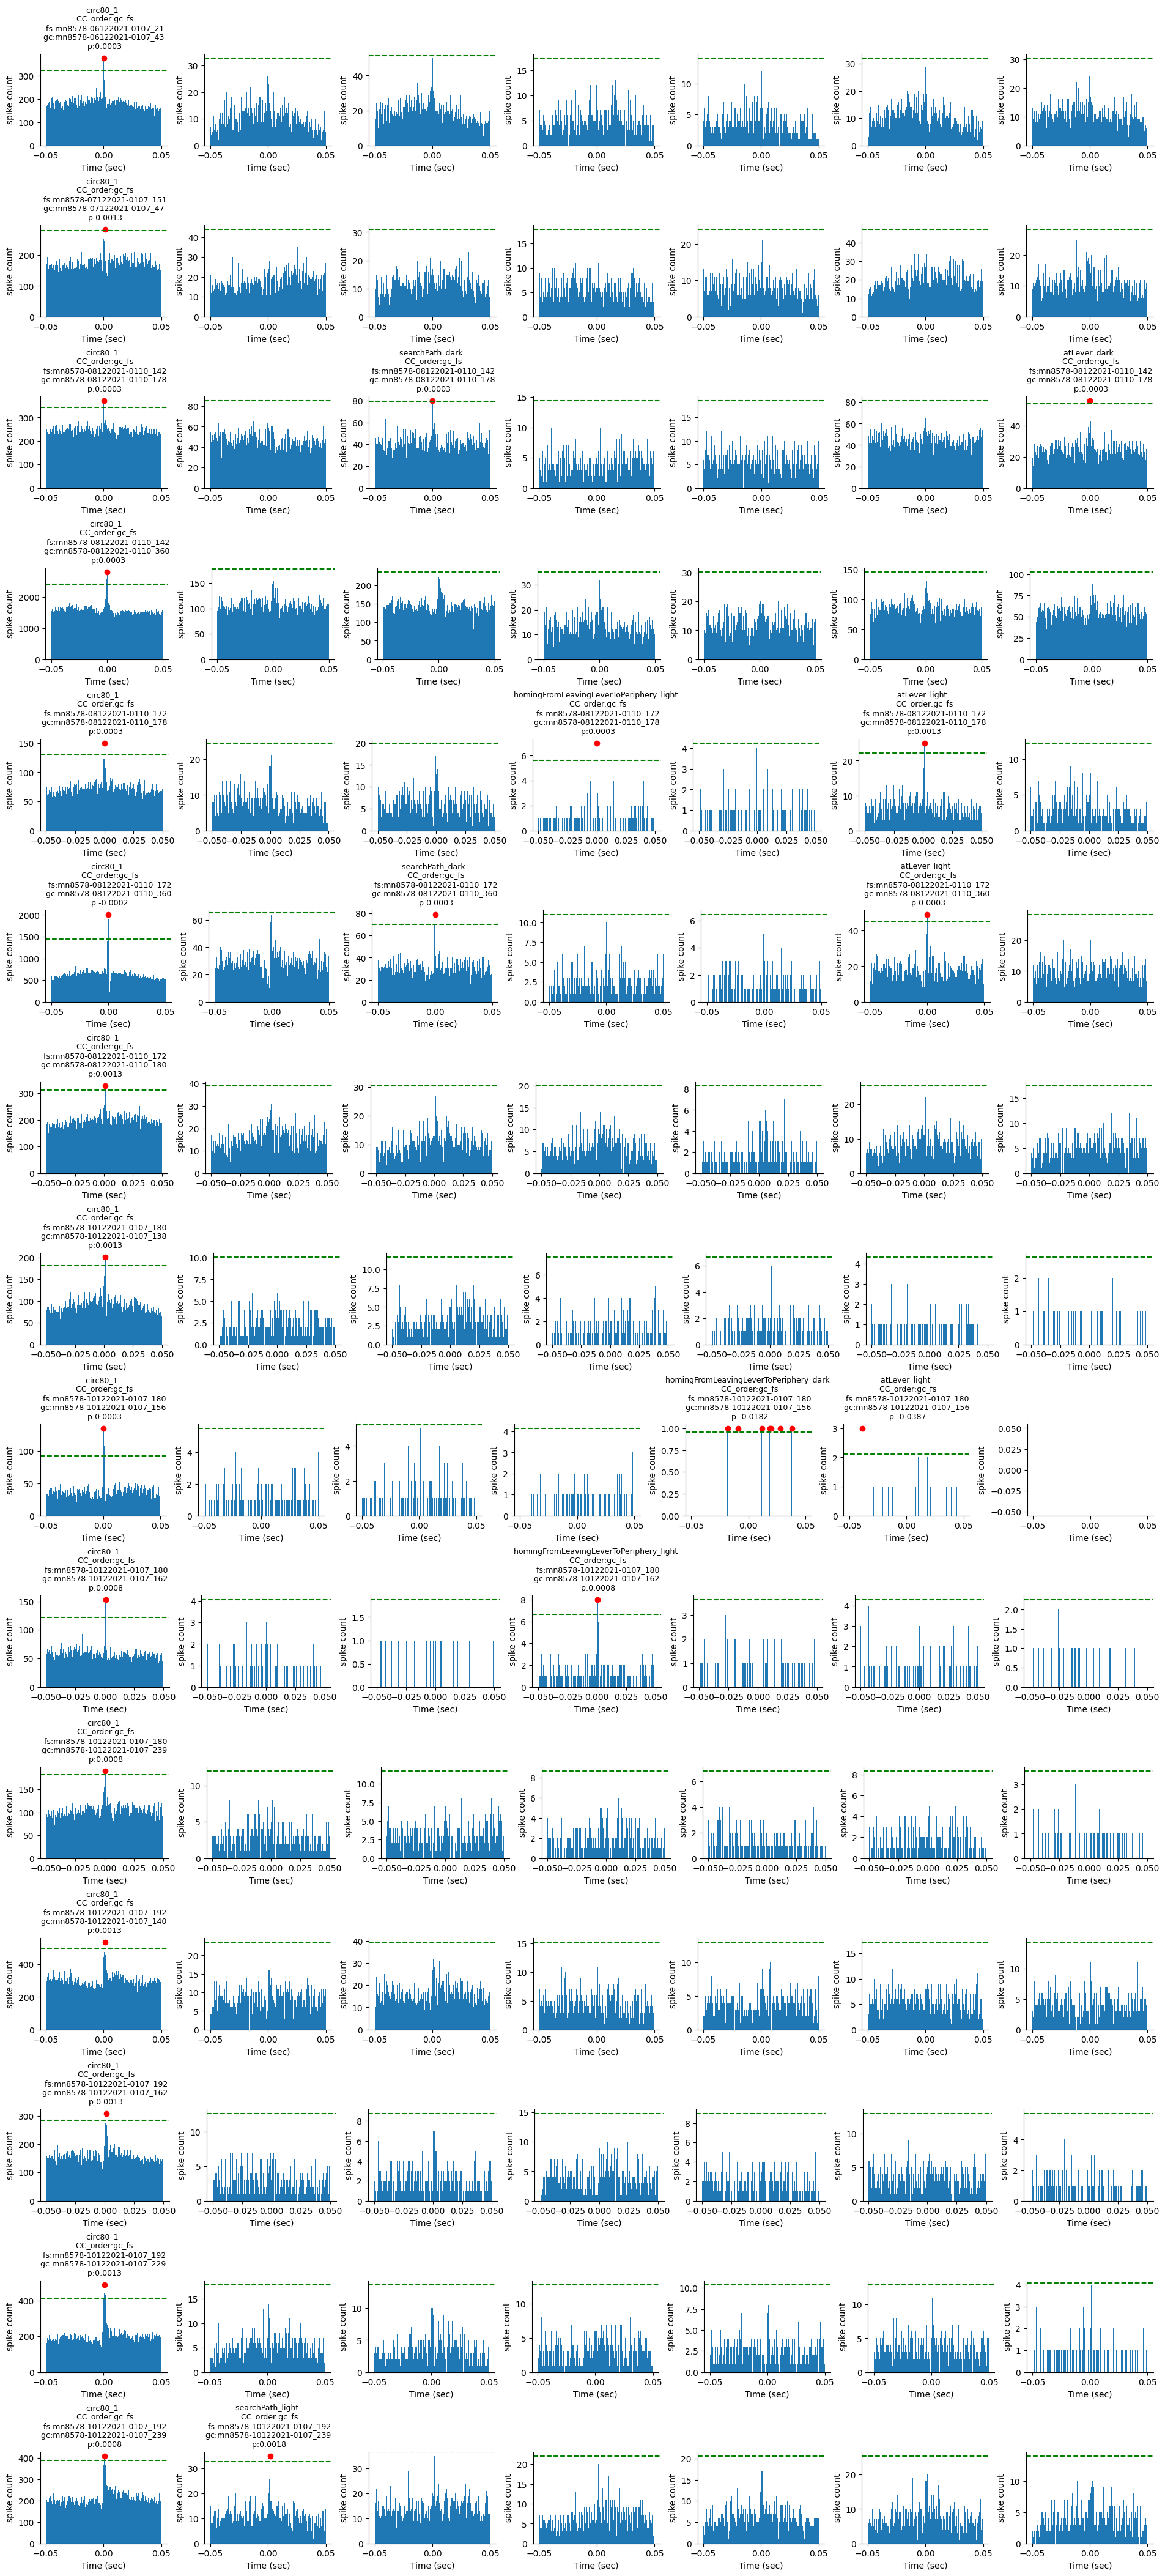

In [174]:
interNames= ['circ80_1', 'searchPath_light', 'searchPath_dark', 
             'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark', 'atLever_light', 'atLever_dark']
dfplot= connected.iloc[:15] 
rowSize, colSize = 2.8,2.7

nrows = connected.iloc[:15].shape[0]
ncols = len(interNames)  # should match interNames length
timestd= 5
cc_cell_order='gc_fs'
fig = plt.figure(figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True)
gs = gridspec.GridSpec(nrows, ncols, figure=fig)


for ind, row in dfplot.iterrows():
    gsintervals = gridspec.GridSpecFromSubplotSpec(1, ncols, subplot_spec=gs[ind, :], wspace=0.0)
    pair = (row.fs_cluId, row.gc_cluId)
    
    for i, interName in enumerate(interNames): 
        timestamp, hist = get_crossCorrPairs_interval(sSes, pair, interName=interName, bin_size_sec=bin_size_sec, cc_cell_order=cc_cell_order)
        p1_time, p1_height = get_p1_FromCrossCorrPairs(hist, timestamp)
        #thr, peaks_heights_above_thr, peak_times = find_peaks_higher_than_threshold(hist, timestamp, timestd)
        thr, highest_peak_above_thr, peak_time= find_highest_peak_above_threshold(hist, timestamp, timestd=6)
        
        ax = fig.add_subplot(gsintervals[i])
        plot_crossCorr_pairs(ax, pair, interName, bin_size_sec, cc_cell_order, timestd)


### Wanna plot the path of the animal for some time and plot the spike on the map of the pairs of the cells  

In [175]:
def get_leverPressTime_session(res, ses, sSes, cond= 'atLever_light'):
    
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values

    #atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    atLever_times = ses.intervalDict[cond]# , ses.intervalDict['atLever_dark']])
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})

    return trial_lever_times

def plot_spikes_onJourneyAtlever(gs, trial_lever_times, n, sSes, tindx= 9, legend= True):

    axes= fig.add_subplot(gs[0])
    t= trial_lever_times[tindx]
    trialNo= t['trial_id']
    #print(trialNo)
    inter= np.array([t['start'],t['end']])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=3)
    axes.axis('Off')
    
    axes= fig.add_subplot(gs[1])
    inter= np.array([t['LeverPress']-0.5,t['LeverPress']+0.5])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=3)
    mid= int(sSes.ap.pose.shape[0]/2) ## lever press is at the middle of the posi 
    #trial= ses.trialList[trialNo]
    #trial.plotLeverPresses(axes)
    axes.scatter(sSes.ap.pose[mid,1],sSes.ap.pose[mid,2], c='red',s=50, label= 'lp')
    axes.axis('Off')
    if legend: 
        ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))

def get_spikeOnmap_pairs(paircluId, interName = 'circ80_1', intertimeSec= 5):
    
    sSes,ses,fsn, fsnid = get_sSesId_nId(paircluId[0])
    sSes,ses,gcn, gcnid = get_sSesId_nId(paircluId[1])

    # Set intervals for spike trains based on intervalDict
    inter= list(ses.intervalDict[interName][0])
    start = np.random.randint(inter[0], inter[1] - intertimeSec)
    inter2= np.array([start, start+intertimeSec])
    
    gcn.spike_train.unset_intervals()
    fsn.spike_train.unset_intervals()
    gcn.spike_train.set_intervals(inter2)
    fsn.spike_train.set_intervals(inter2)

    # Load pose and set intervals
    sSes.ap.load_pose_from_file()
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter2)
    time = sSes.ap.pose[:, 0]

    fsn_spike_posi= fsn.spatial_properties.spike_position()
    gcn_spike_posi= gcn.spatial_properties.spike_position()

    return sSes.ap.pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid

In [177]:
connected.keys()

connected[(connected.connected) & (connected.session == sSes.name)].shape

(1, 14)

In [178]:
ses.intervalDict.keys()
connected.interName.unique()

array(['circ80_1', 'searchPath_light',
       'homingFromLeavingLeverToPeriphery_light', 'atLever_light',
       'atLever_dark', 'searchPath_dark',
       'homingFromLeavingLeverToPeriphery_dark'], dtype=object)

In [196]:
def plot_spikes_Atlever(gs, trial_lever_times, n, sSes, nid, tindx= 7, ntype= 'fs' , interName= 'atLever_light', legend= True):

    axes= fig.add_subplot(gs[0])
    t= trial_lever_times[tindx]
    trialNo= t['trial_id']
    inter= np.array([t['LeverPress']-0.5,t['LeverPress']+0.5])
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    spike_posi=n.spatial_properties.spike_position()
    axes.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='black', alpha=0.3,linewidth=2)
    axes.scatter(spike_posi[:,0],spike_posi[:,1],s=5)
    mid= int(sSes.ap.pose.shape[0]/2) ## lever press is at the middle of the posi 
    #trial= ses.trialList[trialNo]
    #trial.plotLeverPresses(axes)
    axes.scatter(sSes.ap.pose[mid,1],sSes.ap.pose[mid,2], c='red',s=50, label= 'lp')
    axes.set_title(f'{interName}\n {ntype}-nid:{nid} \n t:{tindx}', fontsize= 9)
    axes.axis('Off')
    if legend: 
        axes.legend(loc='upper center', bbox_to_anchor= (1,1))
    
def plot_spikesOnpaths_comparePairs(gs, res, paircluId,df_all_sessions, intertimeSec= 1, tinds=[10,11], pairindx= -1):
    
    ax= fig.add_subplot(gs[0])
    # pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid  = get_spikeonmap_pairs( paircluId, interName , intertimeSec)
    pose, fsn_spike_posi, gcn_spike_posi, fsnid, gcnid = get_spikeOnmap_pairs(paircluId, interName='circ80_1', intertimeSec=intertimeSec)


    ax.plot(pose[:,1], pose[:,2])
    start_pose = pose[0]  # First position
    end_pose = pose[-1]   # Last position

    ax.scatter(start_pose[1], start_pose[2], s=50, c='green', marker='o', label='Start')
    ax.scatter(end_pose[1], end_pose[2], s=50, c='blue', marker='X', label='End')
    ax.scatter(fsn_spike_posi[:,0],fsn_spike_posi[:,1],s=35, c= 'red', label='fs')
    ax.scatter(gcn_spike_posi[:,0],gcn_spike_posi[:,1],s=25, c= 'black', label='gc')
    #ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))
    ax.set_title(f' RF \n connected pairs\n fsid:{fsnid}, gcid:{gcnid}', fontsize= 10)
    ax.axis('off')


    ax= fig.add_subplot(gs[1])
    ## get the not connected pairs with the same fs neuron
    sSes,ses,fsn, fsnid = get_sSesId_nId(paircluId[0])
    df2= df_all_sessions[(df_all_sessions.connected== False) & (df_all_sessions.fs_cluId==paircluId[0] ) & (df_all_sessions.session == sSes.name)].reset_index()
    paircluId2 = df2.fs_cluId.iloc[pairindx], df2.gc_cluId.iloc[pairindx]
    pose, fsn_spike_posi, gcn_spike_posi, fsnid,gcnid  = get_spikeOnmap_pairs(paircluId2, interName = 'circ80_1', intertimeSec= intertimeSec)

    ax.plot(pose[:,1], pose[:,2])
    start_pose = pose[0]  # First position
    end_pose = pose[-1]   # Last position

    ax.scatter(start_pose[1], start_pose[2], s=50, c='green', marker='o', label='Start')
    ax.scatter(end_pose[1], end_pose[2], s=50, c='blue', marker='X', label='End')
    ax.scatter(fsn_spike_posi[:,0],fsn_spike_posi[:,1],s=40, c= 'red', label='fs')
    ax.scatter(gcn_spike_posi[:,0],gcn_spike_posi[:,1],s=25, c= 'black', label='gc')
    ax.legend(loc='upper center', bbox_to_anchor= (1.4,1))
    ax.set_title(f'RF \n not-connected pairs\n fsid:{fsnid}, gcid:{gcnid}', fontsize= 10)
    ax.axis('off')

    # Conditions and time indices
    conditions = [('atLever_light', tinds[0]), ('atLever_dark', tinds[1])]

    # Define fs and gc pairs (fs from paircluId[0], gc from paircluId[1] and paircluId2[1])
    pairs = [
        ('fs', paircluId[0], False),  # fs neuron
        ('gc', paircluId[1], False),   # gc neuron from paircluId
        ('gc', paircluId2[1], True)   # gc neuron from paircluId2
    ]

    for i, (cond, tindx) in enumerate(conditions):  # Iterate over light/dark conditions
        for j, (ntype, cluid, legend) in enumerate(pairs):  # Iterate over fs, gc neurons
            gs_sub = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 2 + j + (i * 3):3 + j + (i * 3)])

            sSes, ses, clun, clunid = get_sSesId_nId(cluid)
            trial_lever_times = get_leverPressTime_session(res, ses, sSes, cond=cond)
            plot_spikes_Atlever(gs_sub, trial_lever_times, clun, sSes, nid=clunid, tindx=tindx, ntype=ntype, interName=cond, legend=legend)


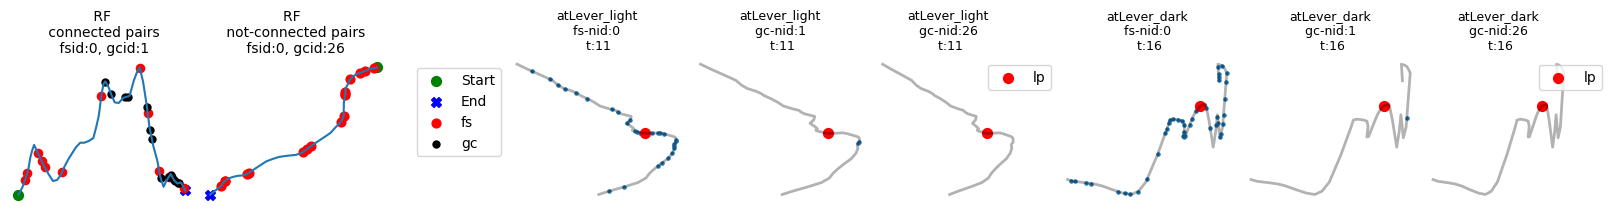

In [197]:
col = 8
row = 1
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


paircluId =crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected)].fs_cluId.iloc[0], crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected)].gc_cluId.iloc[0]
plot_spikesOnpaths_comparePairs(gs,res, paircluId,crossCorr_pairs_allsessions_df, intertimeSec= 1 , tinds=[11,16], pairindx= -1)

In [187]:
interName = 'circ80_1'
condf= crossCorr_pairs_allsessions_df[ (crossCorr_pairs_allsessions_df.connected)]
ncondf= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected== False) ]

#for indx in condf.shape[0]:
print(ncondf.shape, condf.shape)

(30089, 13) (1033, 13)


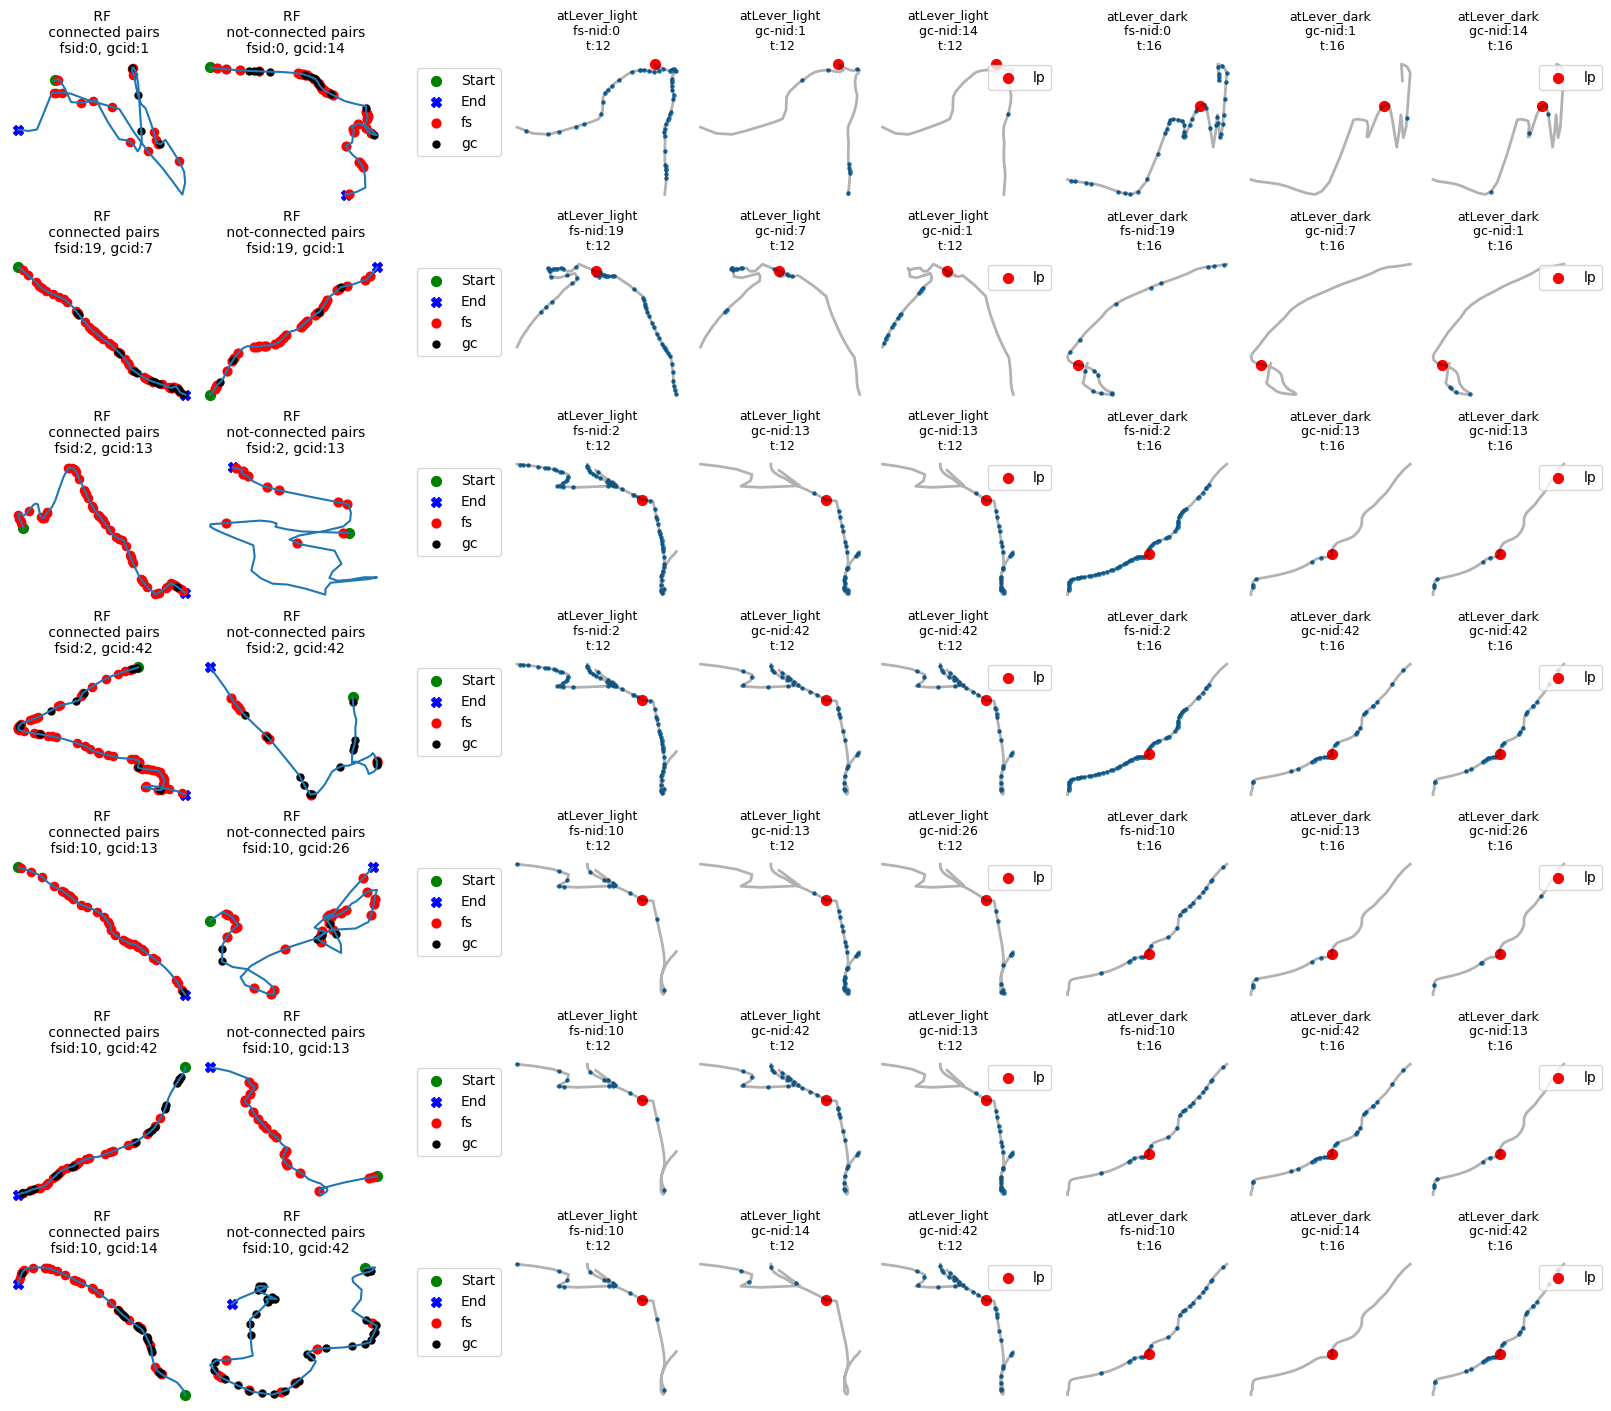

In [189]:
col =8
row = condf.iloc[10:17].shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

for indx in range(condf.iloc[10:17].shape[0]):
    #print(indx)
    gsi = gridspec.GridSpecFromSubplotSpec(1,8,subplot_spec= gs[indx,:], wspace=0.0)
    paircluId =condf[(condf.connected)].fs_cluId.iloc[indx], condf[(condf.connected)].gc_cluId.iloc[indx]
    plot_spikesOnpaths_comparePairs(gsi,res, paircluId,crossCorr_pairs_allsessions_df, intertimeSec= 1 , tinds=[12,16], pairindx=indx )

### find the cells that have their expValu close to zero and have are a pair of connecetd fs and gc 

In [190]:
fn= 'fsgc_expvalues.csv'
expvaldf = pd.read_csv(fn)

expvaldf

,expval,cluId,light,session,cellType
0,0.022739,mn8578-05122021-0108_241,light,mn8578-05122021-0108,fs
1,0.016763,mn8578-05122021-0108_241,dark,mn8578-05122021-0108,fs
2,0.039065,mn8578-06122021-0107_21,light,mn8578-06122021-0107,fs
3,0.028421,mn8578-06122021-0107_21,dark,mn8578-06122021-0107,fs
4,-0.005364,mn8578-07122021-0107_30,light,mn8578-07122021-0107,fs
...,...,...,...,...,...
2969,0.027341,jp499-18052023-0108_761,dark,jp499-18052023-0108,gc
2970,-0.007099,jp499-25052023-0108_382,light,jp499-25052023-0108,gc
2971,0.128192,jp499-25052023-0108_398,light,jp499-25052023-0108,gc
2972,0.129089,jp499-25052023-0108_382,dark,jp499-25052023-0108,gc


In [191]:
fsclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId
fsclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='fs')].cluId

gcclu_light= expvaldf[(expvaldf.light=='light')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId
gcclu_dark= expvaldf[(expvaldf.light=='dark')&(expvaldf.expval<0.01) & (expvaldf.expval>-0.01) & (expvaldf.cellType=='gc')].cluId

In [193]:
fsclu_light.shape, fsclu_dark.shape, crossCorr_pairs_allsessions_df.keys()

((234,),
 (234,),
 Index(['session', 'interName', 'pair_type', 'fs_cluId', 'gc_cluId', 'hist',
        'timestamp', 'p1_time', 'p1_height', 'peak_threshold',
        'peaks_heights_above_thr', 'peak_times', 'connected'],
       dtype='object'))

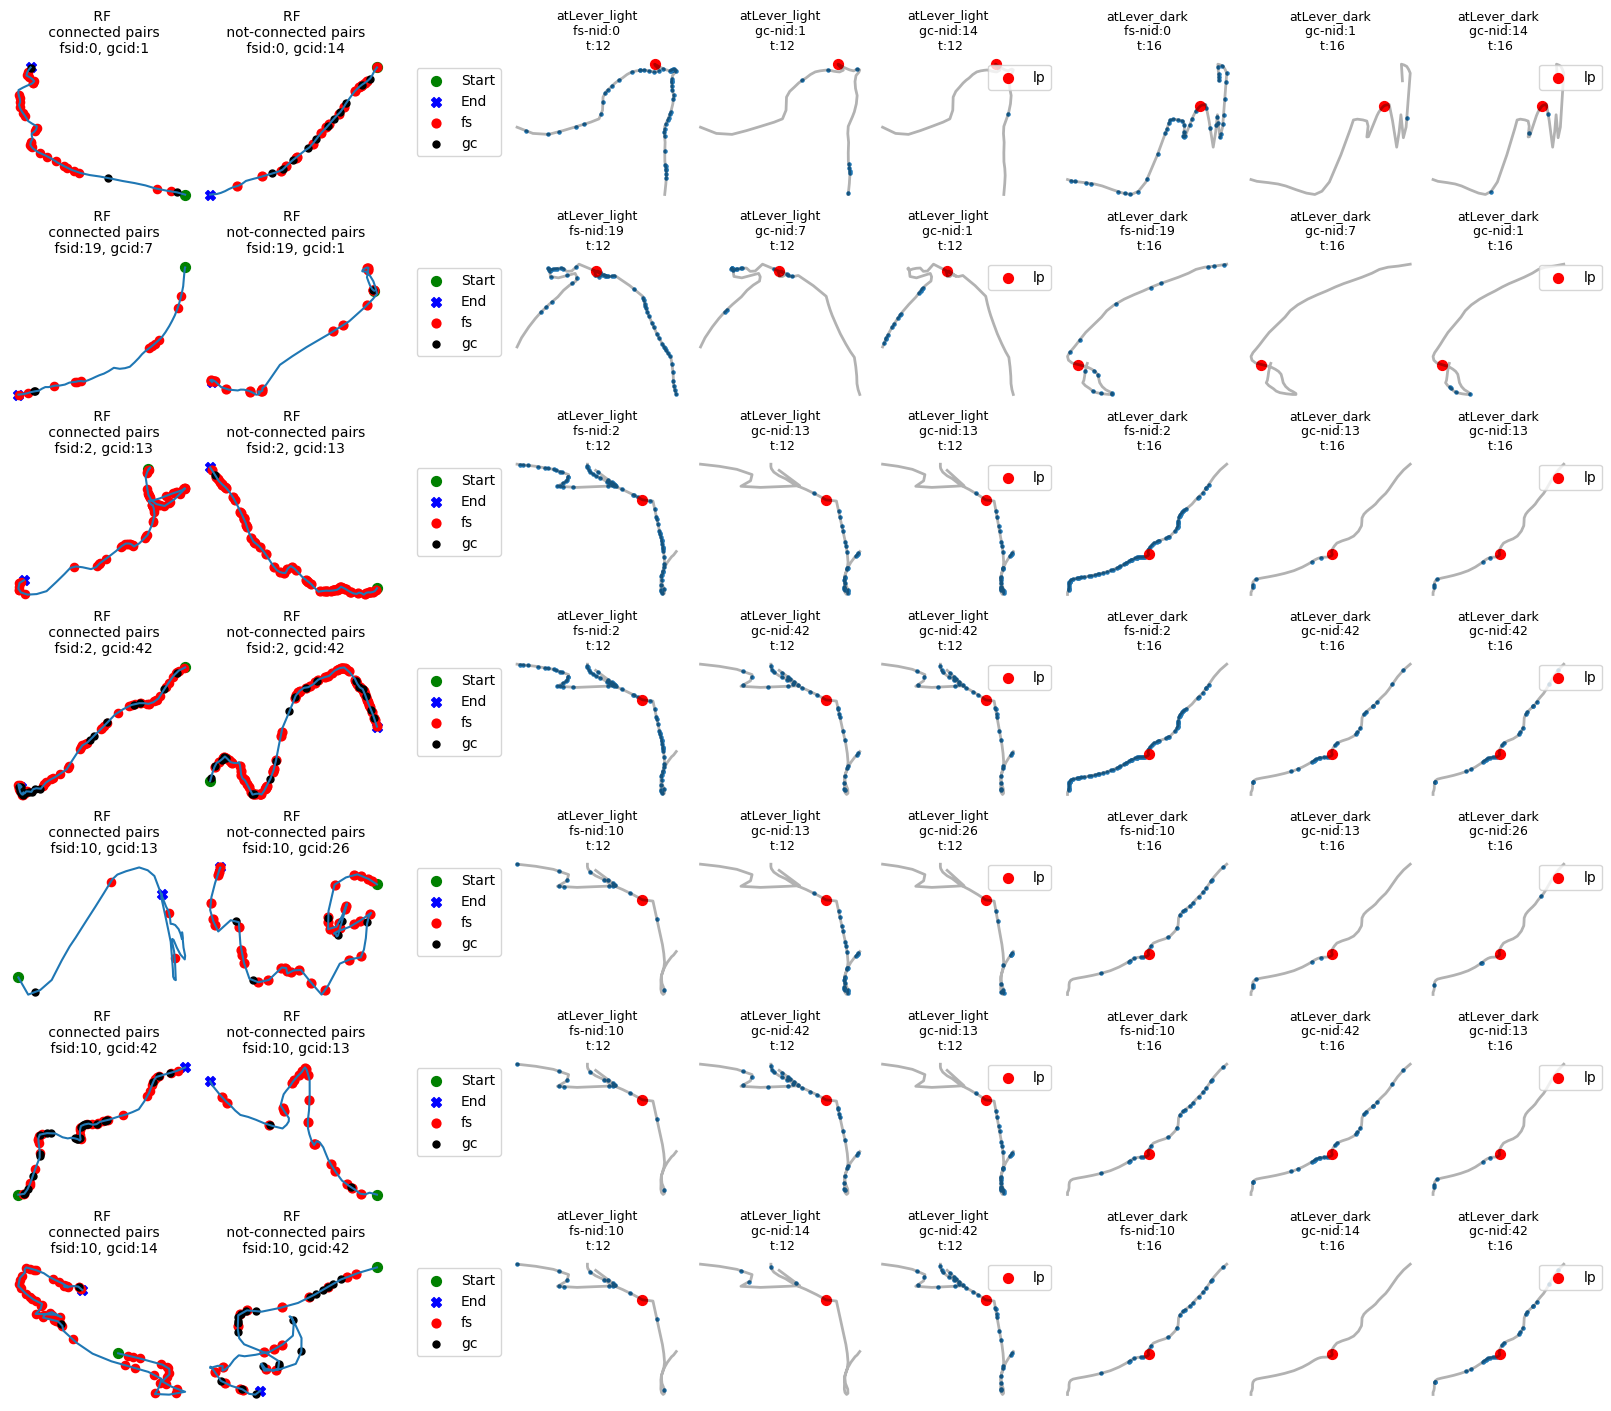

In [198]:
df= crossCorr_pairs_allsessions_df[(crossCorr_pairs_allsessions_df.connected) & (crossCorr_pairs_allsessions_df.fs_cluId.isin(fsclu_light))]

col =8
row = df.iloc[10:17].shape[0]
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

for indx in range(df.iloc[10:17].shape[0]):
    #print(indx)
    gsi = gridspec.GridSpecFromSubplotSpec(1,8,subplot_spec= gs[indx,:], wspace=0.0)
    paircluId =condf[(condf.connected)].fs_cluId.iloc[indx], condf[(condf.connected)].gc_cluId.iloc[indx]
    plot_spikesOnpaths_comparePairs(gsi,res, paircluId,crossCorr_pairs_allsessions_df, intertimeSec= 1 , tinds=[12,16], pairindx=indx )

Try a cell that has a expected value close to zero 

In [ ]:
celltoplots= fsclu_light.iloc[:5]
cid= celltoplots.iloc[1]
sSes,ses,n, nid = get_sSesId_nId(cid)
#loadTrials(ses,sSes)


Write a fun that finds the valid trials that have at least one valid journeys and then plot them 

7
9
11


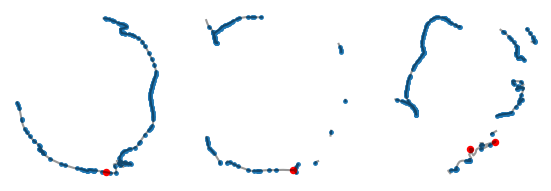

In [ ]:
col = 3  # Number of columns in the grid
row = 1  # Number of rows in the grid
sizePerRow, sizePerCol = figurePanelDefaultSize()

# Create the figure and grid spec with the required size
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.2)

# Iterate over the trial numbers and plot each valid trial on a separate subplot
valid_trial_count = 0  # Keep track of the number of valid trials

for i, trialNo in enumerate(range(len(ses.trialList[7:20]))):
    t = ses.trialList[trialNo]
    if t.valid:
        print(trialNo)
        j = t.journeyList[-1]
        
        # Create a new axis for each valid trial
        if valid_trial_count < row * col:
            axes = fig.add_subplot(gs[valid_trial_count])

            # Set intervals and plot the journey path and spike positions
            inter = np.array([[j.startTime, j.endTime]])
            sSes.ap.unset_intervals()
            inter = RosToResTime(inter.flatten(), np.stack([sSes.ap.pose[:, 0], sSes.ap.pose[:, 7]], axis=1)).reshape((-1, 2))
            n.spike_train.set_intervals(inter)
            sSes.ap.set_intervals(inter)
            spike_posi = n.spatial_properties.spike_position()
            t.plotLeverPresses(axes, s=19)
            axes.plot(j.navPaths["all"].pPose[:, 0], j.navPaths["all"].pPose[:, 1], color="black", alpha=0.4)
            axes.scatter(spike_posi[:, 0], spike_posi[:, 1], s=6)

            # Hide axis borders for cleaner visualization
            axes.axis('Off')
            
            valid_trial_count += 1

